# Anomaly detection in GPU data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import time
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_formats = ['retina']
sns.set_style("darkgrid")
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['figure.figsize'] = [13.5, 5.]
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['legend.fontsize'] = 17
plt.rcParams['legend.frameon'] = True

## Data processing

In [3]:
with open('functimes_combined.dat', "r") as f:
    raw_data = [x.strip("\n").split() for x in f.readlines()]

In [281]:
# from collections import defaultdict

# run_time_dic = defaultdict(list)
# for i in raw_data:
#     func_name = []
#     for j in range(len(i)):
#         if not i[j].isdigit(): # get the func name
#             func_name.append(i[j])
#         else:
#             runtime = [int(x) for x in i[j:]]
#             key = "_".join(func_name).strip('\"')
#             # using defaultdict in case we encounter repeated keys
#             # if a key already exists, then the new runtime list will append to the existing list
#             run_time_dic[key].append(runtime) 
#             break # exit the loop once we find the position of the first numeric element

In [4]:
run_time = {}
for i in raw_data:
    func_name = []
    for j in range(len(i)):
        if not i[j].isdigit(): # get the func name
            func_name.append(i[j])
        else:
            runtime = [int(x) for x in i[j:]]
            key = "_".join(func_name).strip('\"')
            # if a key already exists, then the new runtime list will append to the existing list
            value = run_time.get(key)
            if value == None:
                run_time[key] = runtime
            else:
                run_time[key] = value.append(runtime)
    
            break # exit the loop once we find the position of the first numeric element

We see that the length of` (run_time)` isn't equal to the raw data

In [461]:
len(run_time), len(raw_data)

(531, 533)

We can collect the function name and check if anything is wrong:

In [277]:
fun_name = []

for i in raw_data:
    func_name = []
    for j in range(len(i)):
        if not i[j].isdigit(): 
            func_name.append(i[j]) # get the func name
    key = "_".join(func_name).strip('\"')
    fun_name.append(key)

In [374]:
for name, i in zip(fun_name, range(len(fun_name))):
    try:
        run_time[name]
    except:
        print(name, i)

TOTAL 82
 354


If we check the original data file we will notice this is really the case. No runtime data follows `TOTAL`. And their is a blank entry in line 354.

Next let's select the most frequently called functions:

In [5]:
len_list = []
for key, value in run_time.items():
    len_list.append(len(run_time[key]))

In [7]:
df_len = pd.DataFrame(len_list, index=run_time.keys())
df_len = df_len.reset_index()
df_len = df_len.rename(columns={"index": 'func_name', 0:'call_times'})
df_len = df_len.sort_values('call_times', ascending = False)

In [8]:
df_len.head(10)

,func_name,call_times
224,OpenACC_enqueue_data_transfer_(HtoD),4532940
484,MPI_Type_size(),2329304
116,OpenACC_create,2309544
529,OpenACC_delete,2309270
166,OpenACC_enqueue_upload,1937265
521,Stream_Synchronize,1929195
202,OpenACC_wait,1715497
413,MPI_Waitany(),1685640
44,MPI_Start(),1675360
97,Memory_copy_Host_to_Device,1616603


In [9]:
df_freq = df_len[df_len['call_times'] > 10000]
subset = df_freq.sample(frac = 0.5, random_state = 1)

In [10]:
def sample_portion(dic, func, frac = 0.3):    
    func_runtime = dic[func]
    # total length of the sample
    length = int(len(func_runtime) * frac)
    # select where to start taking the data
    start_position = np.random.randint(0, (len(func_runtime) - length))
    sample_runtime = func_runtime[start_position : start_position + length]
    df_sample = pd.DataFrame({'run_time' : sample_runtime})
    df_sample.name = func
    
    return df_sample   

In [11]:
i = np.random.randint(len(subset))
func_name = subset.iloc[i].func_name
sample = sample_portion(run_time, func_name)

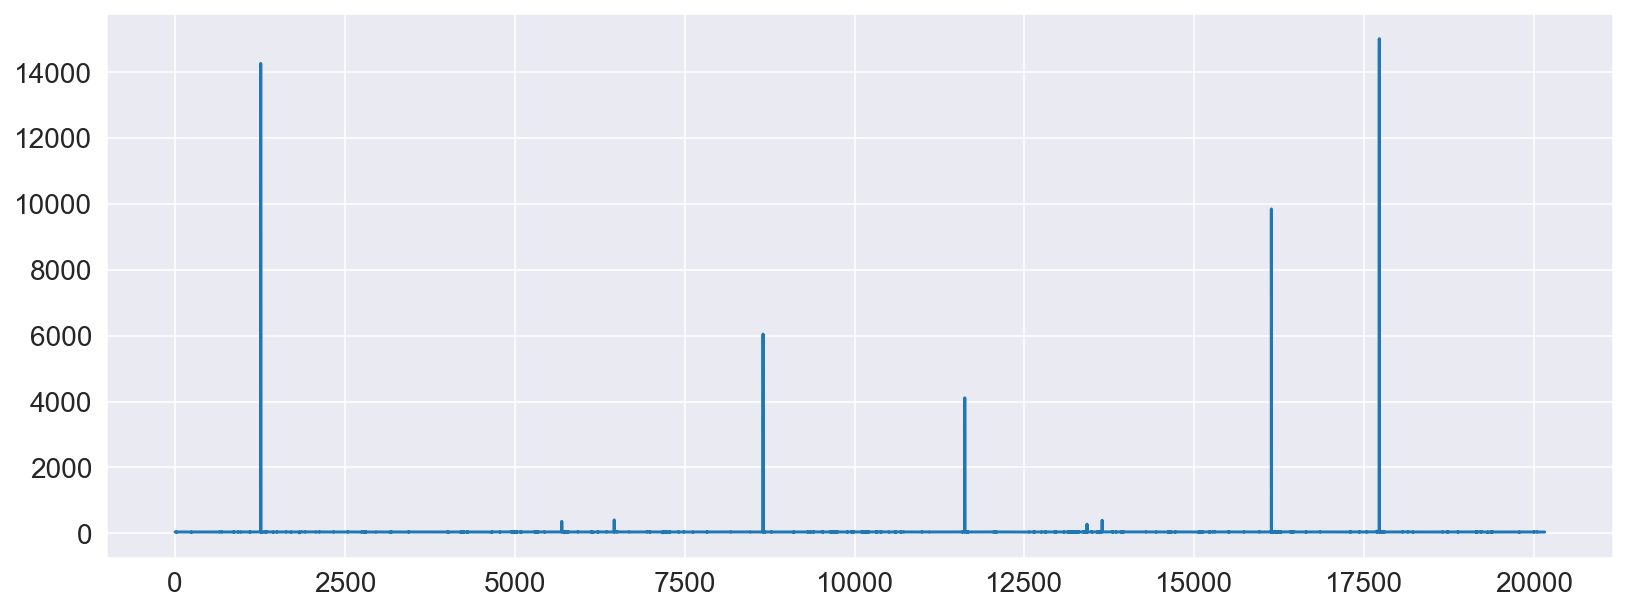

In [12]:
sample.run_time.plot();

In [13]:
def plot_result(outlier, normal, method, *args):
    total_points = len(outlier) + len(normal)
    ratio = len(outlier) / total_points
    para = args
    plt.figure()
    if ratio >= 0.01:
        plt.title("{}, outlier_ratio={:.2f}".format(method, ratio))
    else:
        plt.title("{}, {} outliers in {} points".format(method, len(outlier), total_points))
    g = plt.scatter(normal.index,  normal['run_time'], c='green', s=15, edgecolor='k')
    h = plt.scatter(outlier.index, outlier['run_time'], c='red', s=55, edgecolor='k')
    #plt.xlabel('timestamp', fontsize=15)
    plt.ylabel('run_time', fontsize=15)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.axis('tight')
    plt.legend([g, h],["Normal","Outlier"], prop={'size': 15})
    plt.show()

## Moving Gaussian

In [14]:
def moving_gaussian(df, window_frac = 0.2, c = 6, plot = True):
    window = int(window_frac * len(df))
    mean = df.run_time.rolling(window = window).mean()
    mean.iloc[:(window-1)] = mean.iloc[window]
    std = df.run_time.rolling(window = window).std()
    std.iloc[:(window-1)] = std.iloc[window]

    upper = mean + c * std
    lower = mean - c * std
    a1 = df.run_time > upper
    a2 = df.run_time < lower
    
    anomalies = np.logical_or(a1, a2)
    normal = np.logical_not(anomalies)
    outlier = df[anomalies]
    normal = df[normal]
    
    if plot:
        plot_result(outlier, normal, 'Gaussian')    
    return outlier, normal

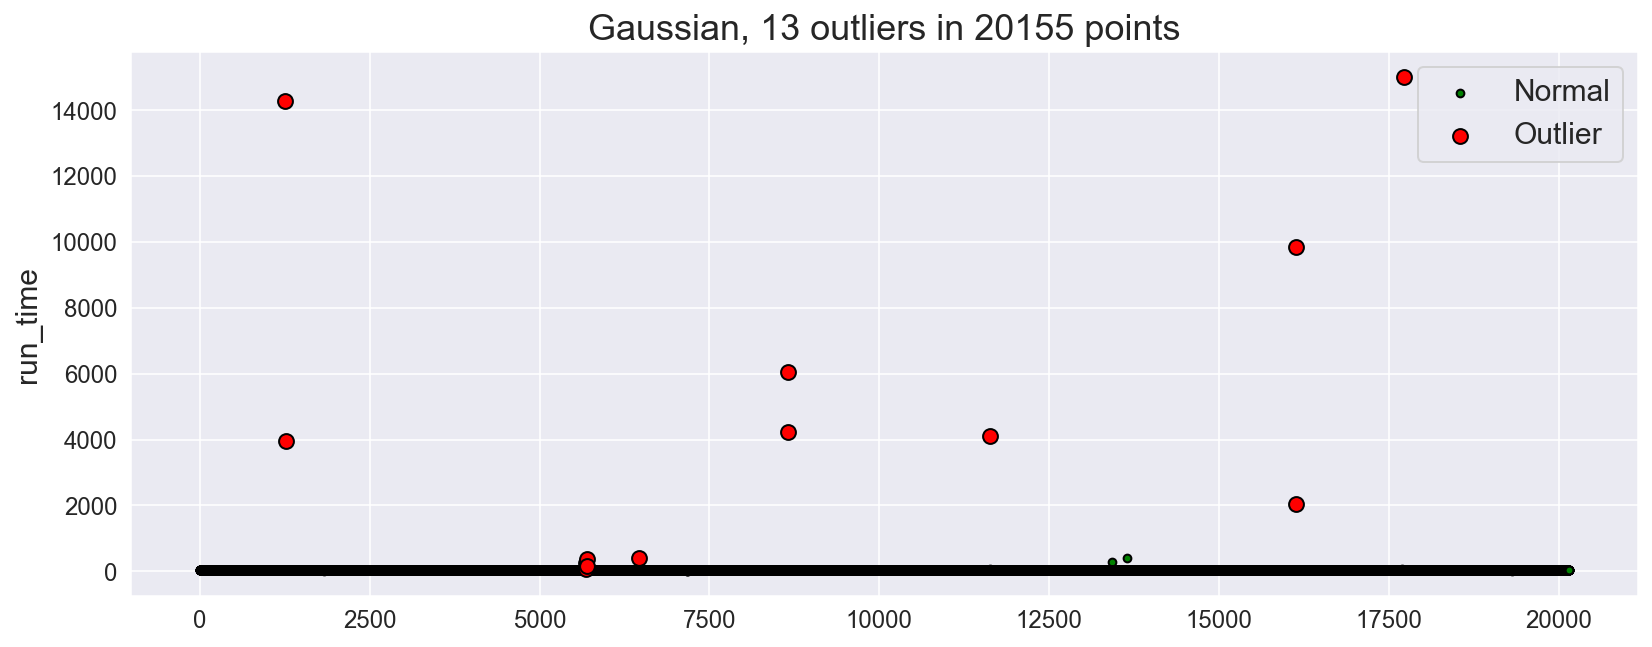

In [15]:
moving_gaussian(sample, plot=True);

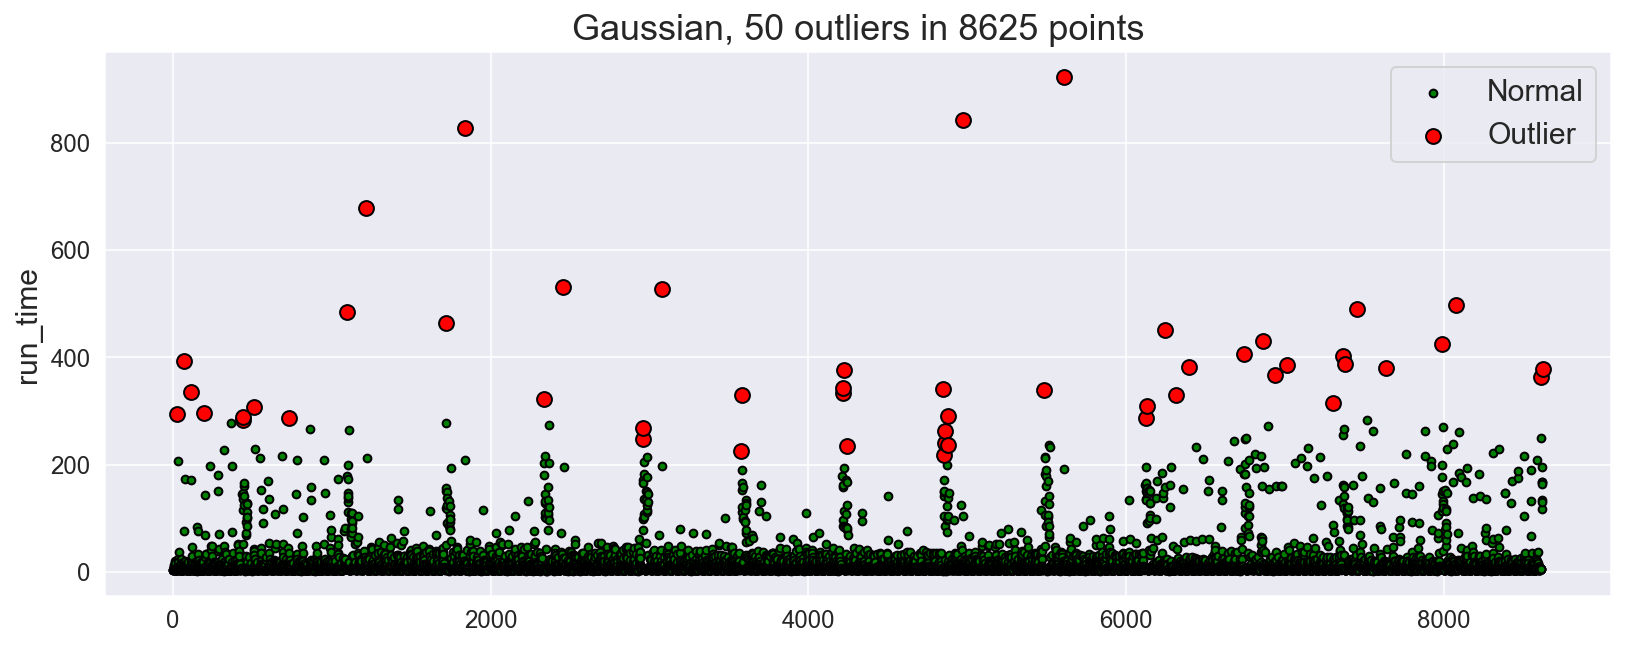

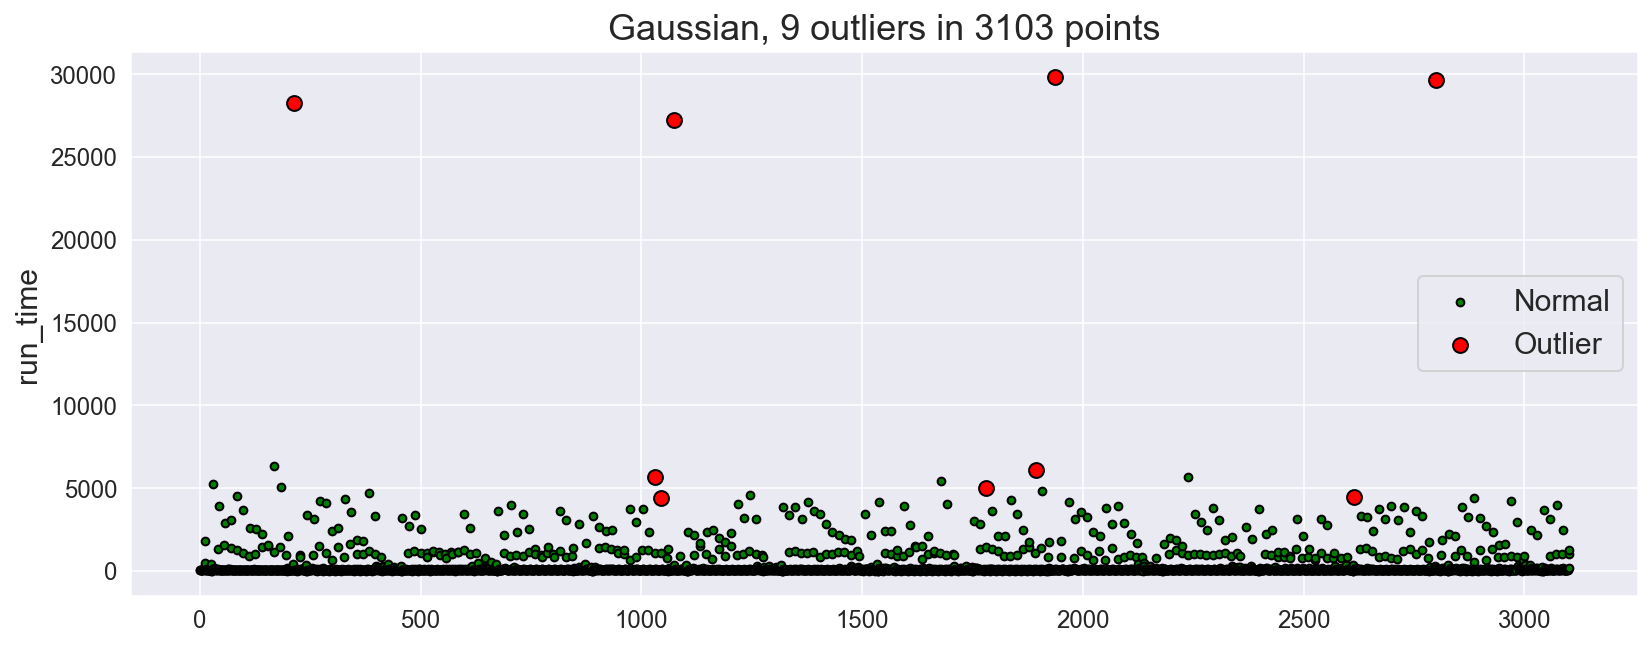

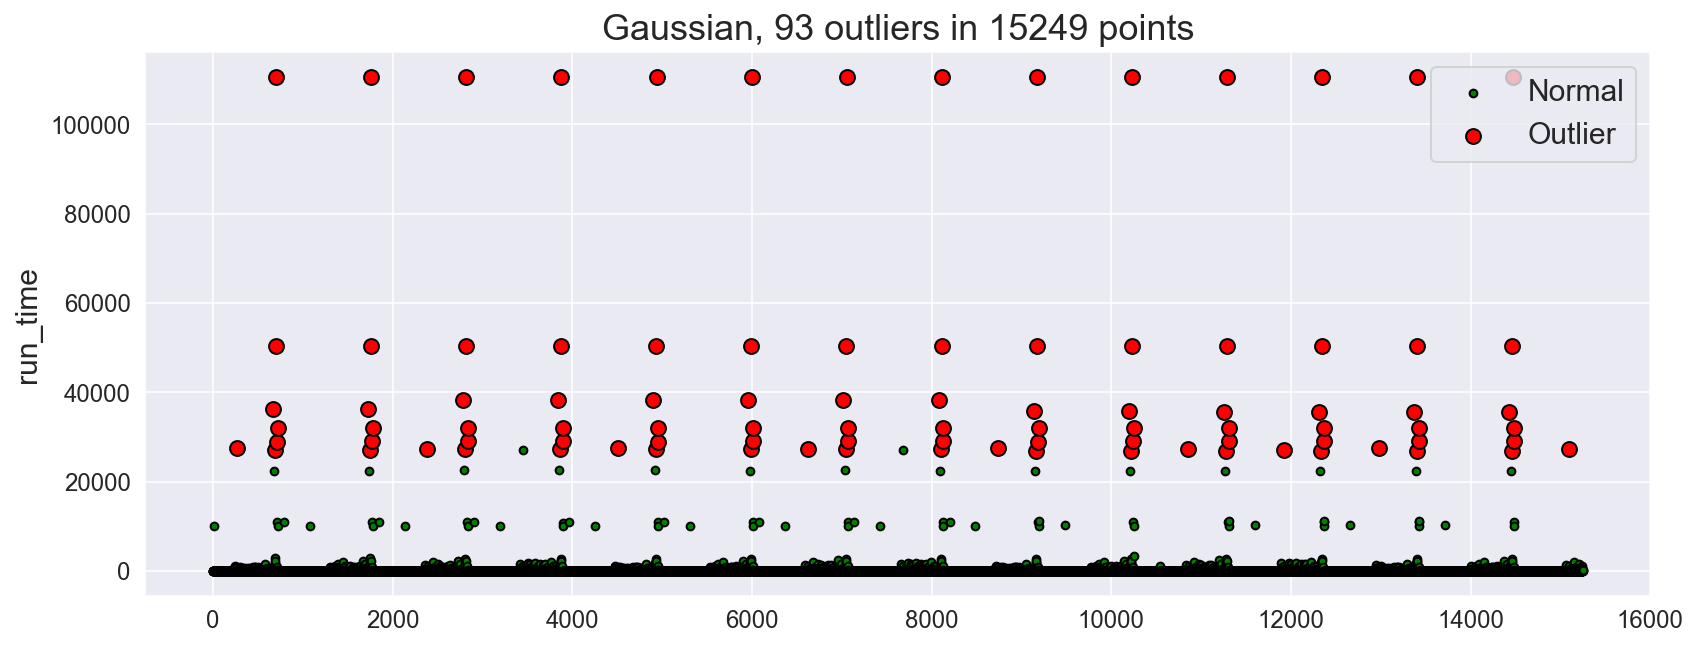

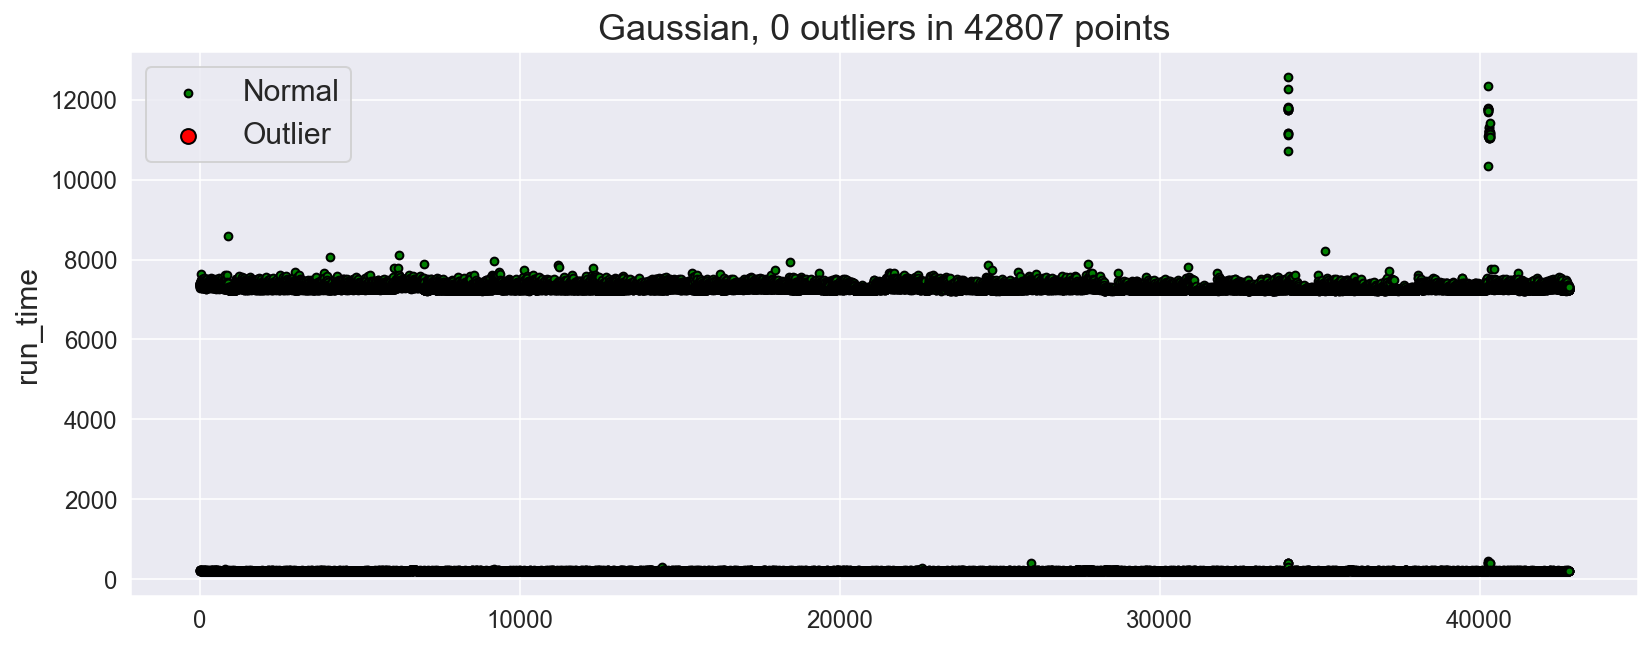

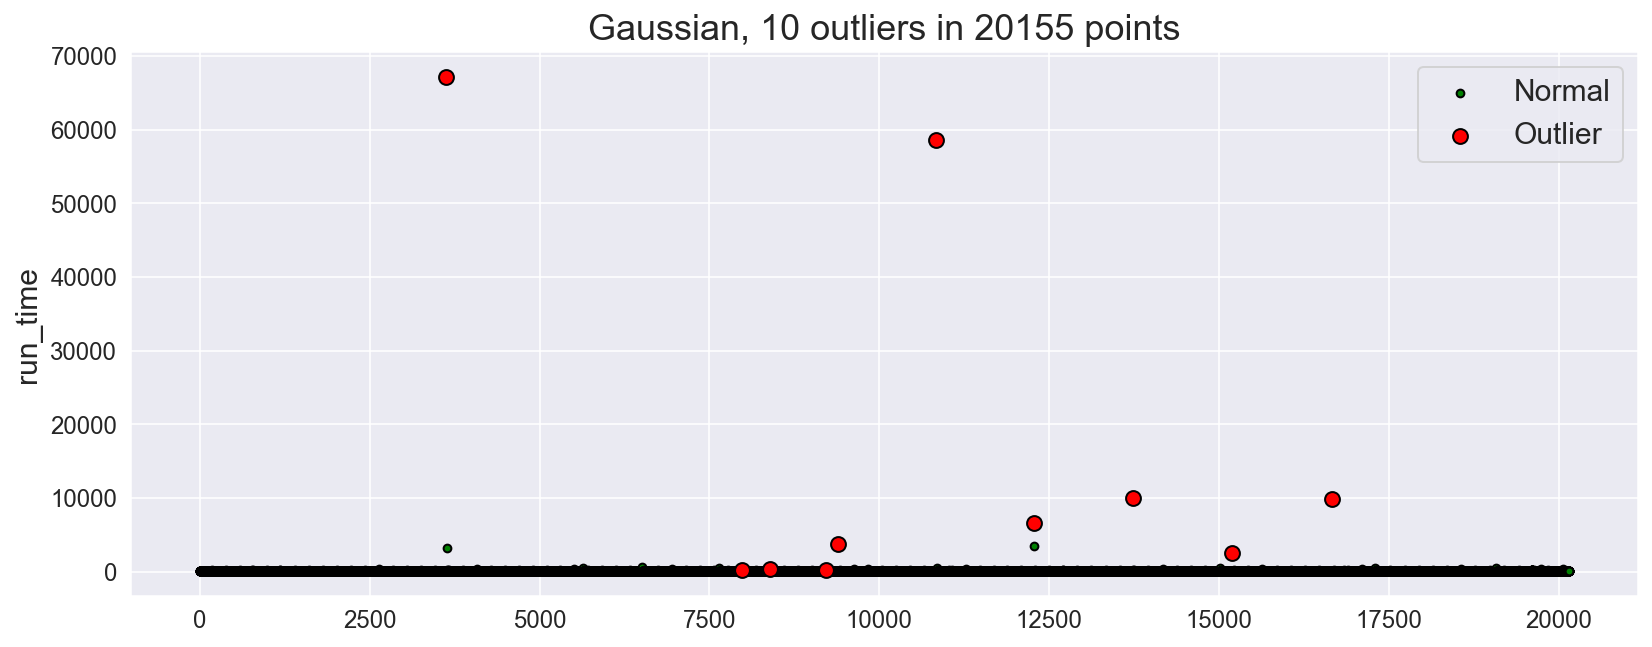

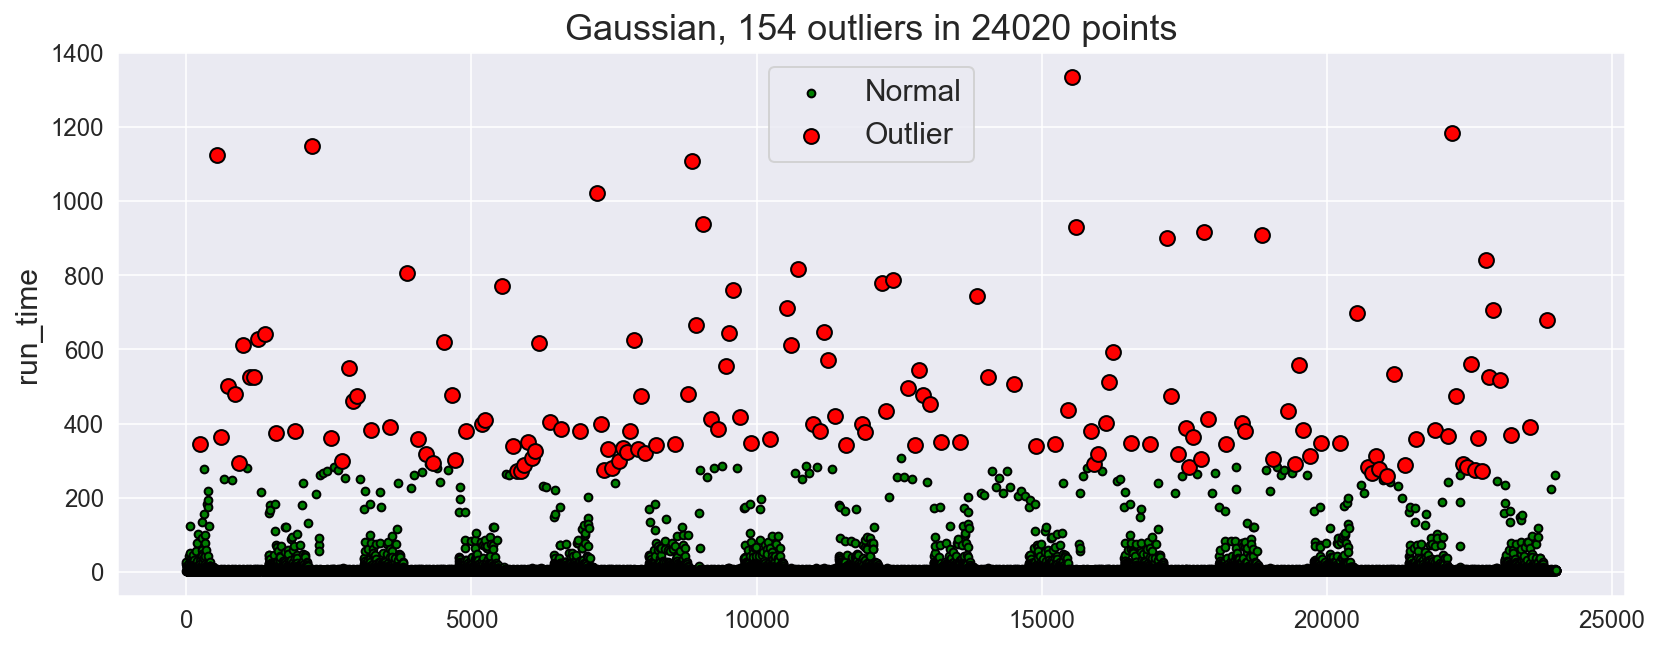

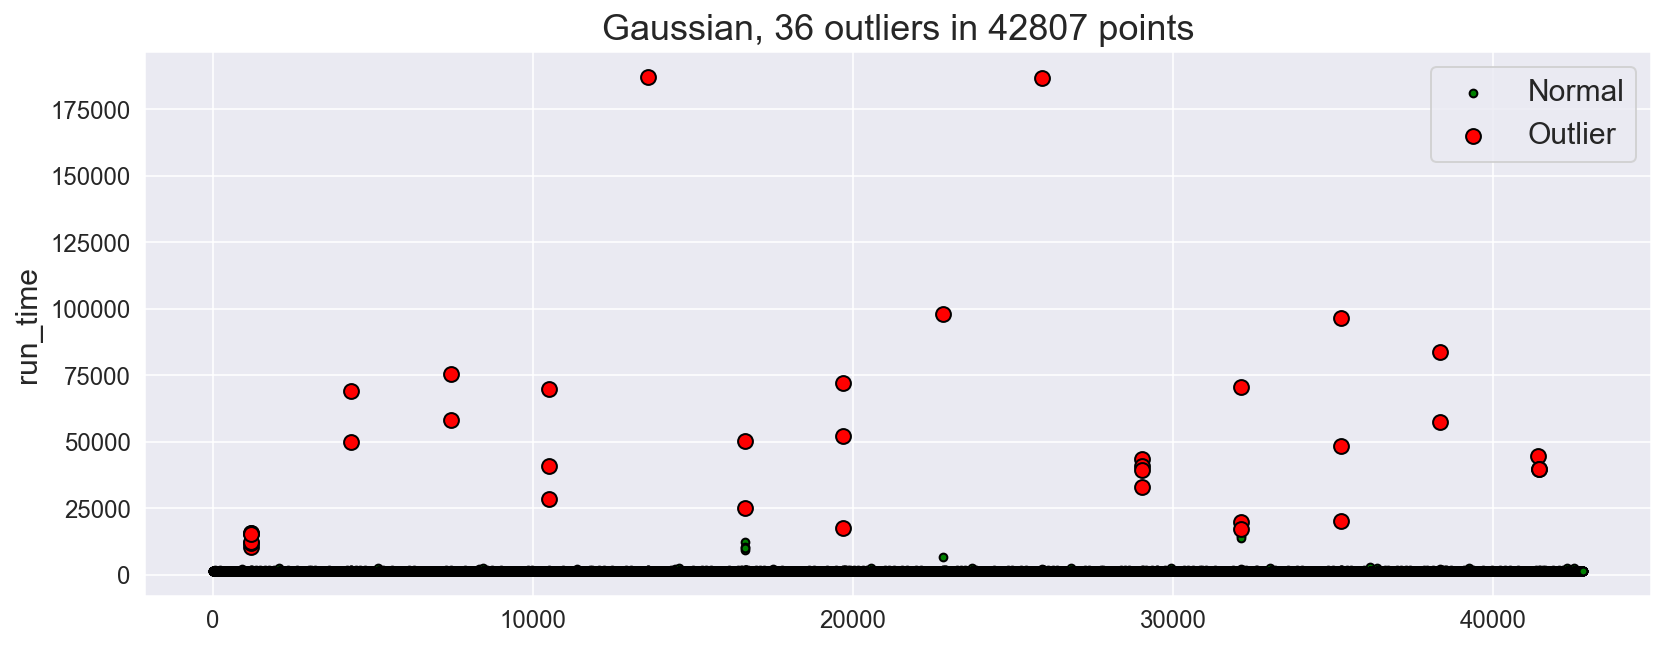

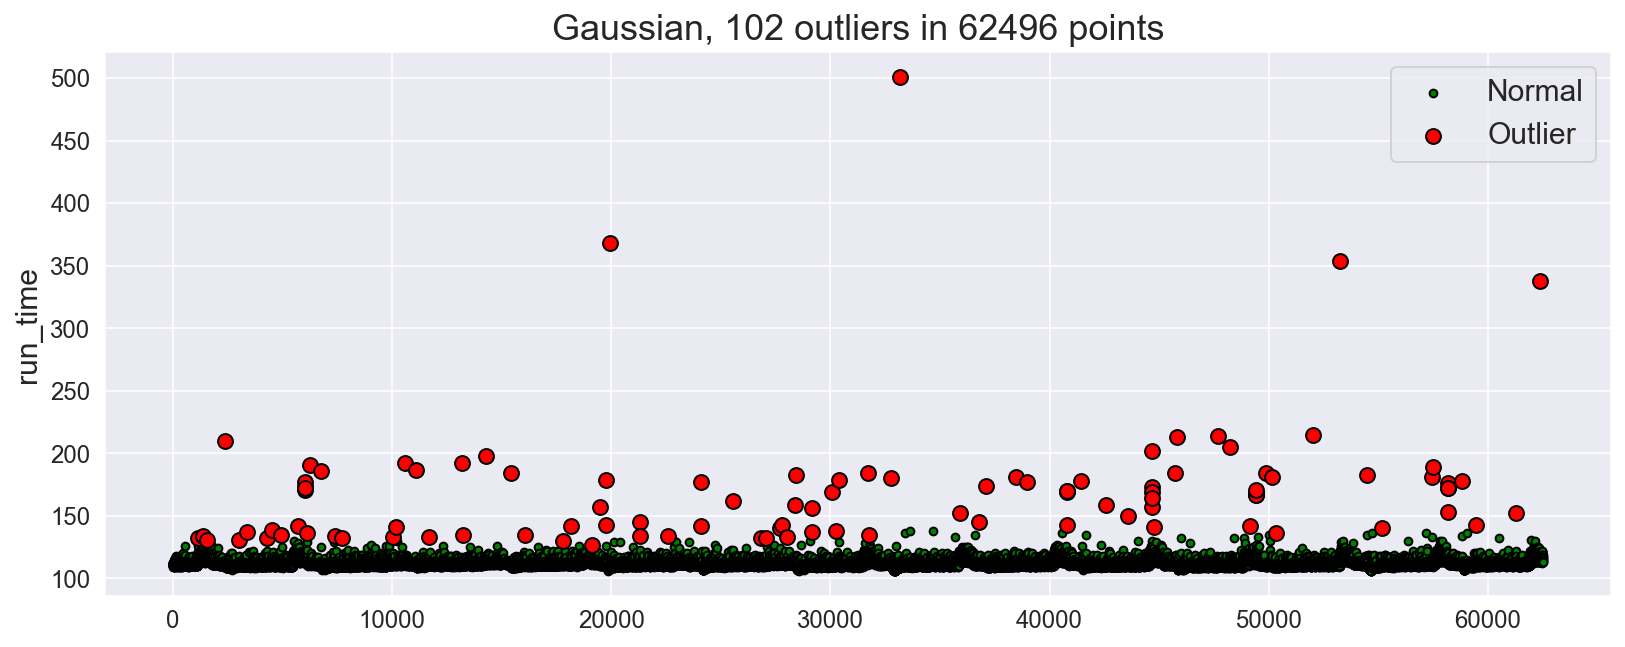

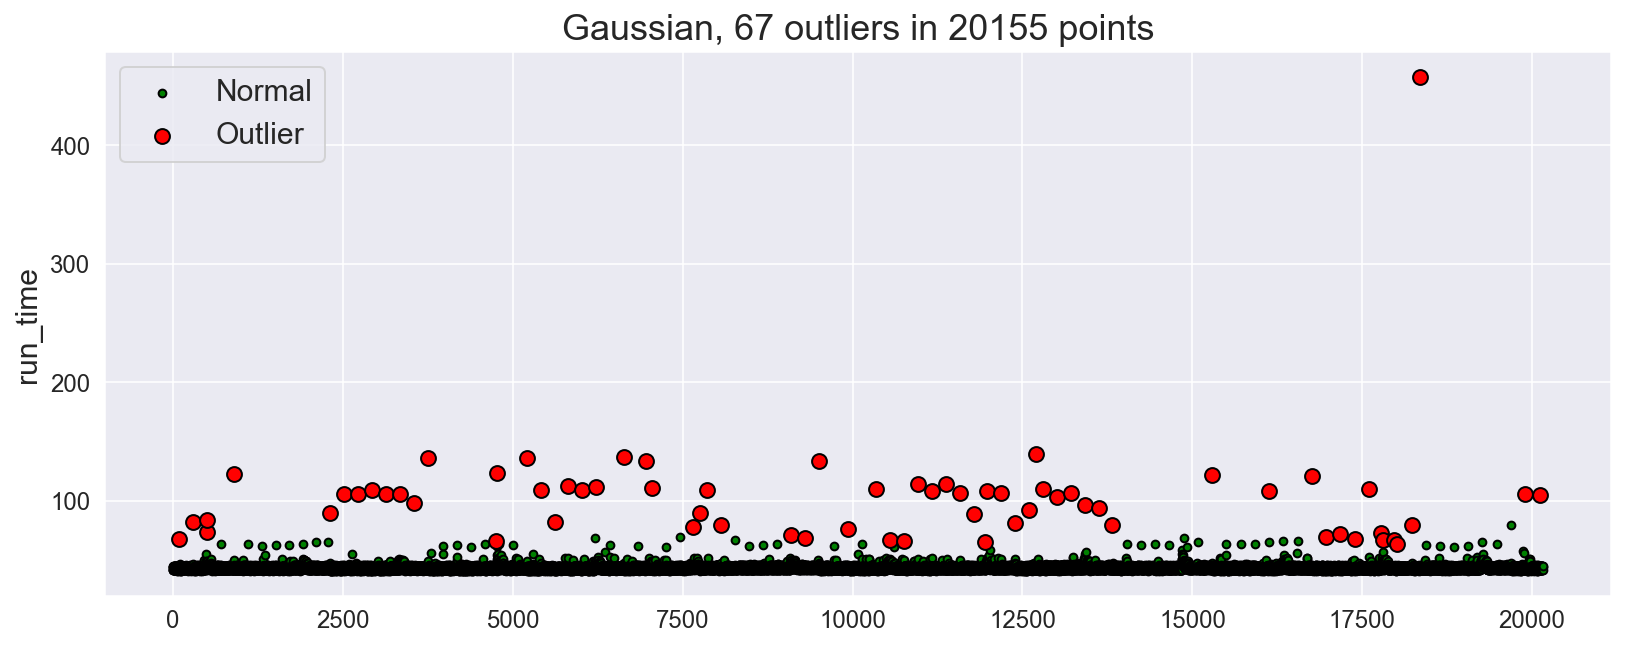

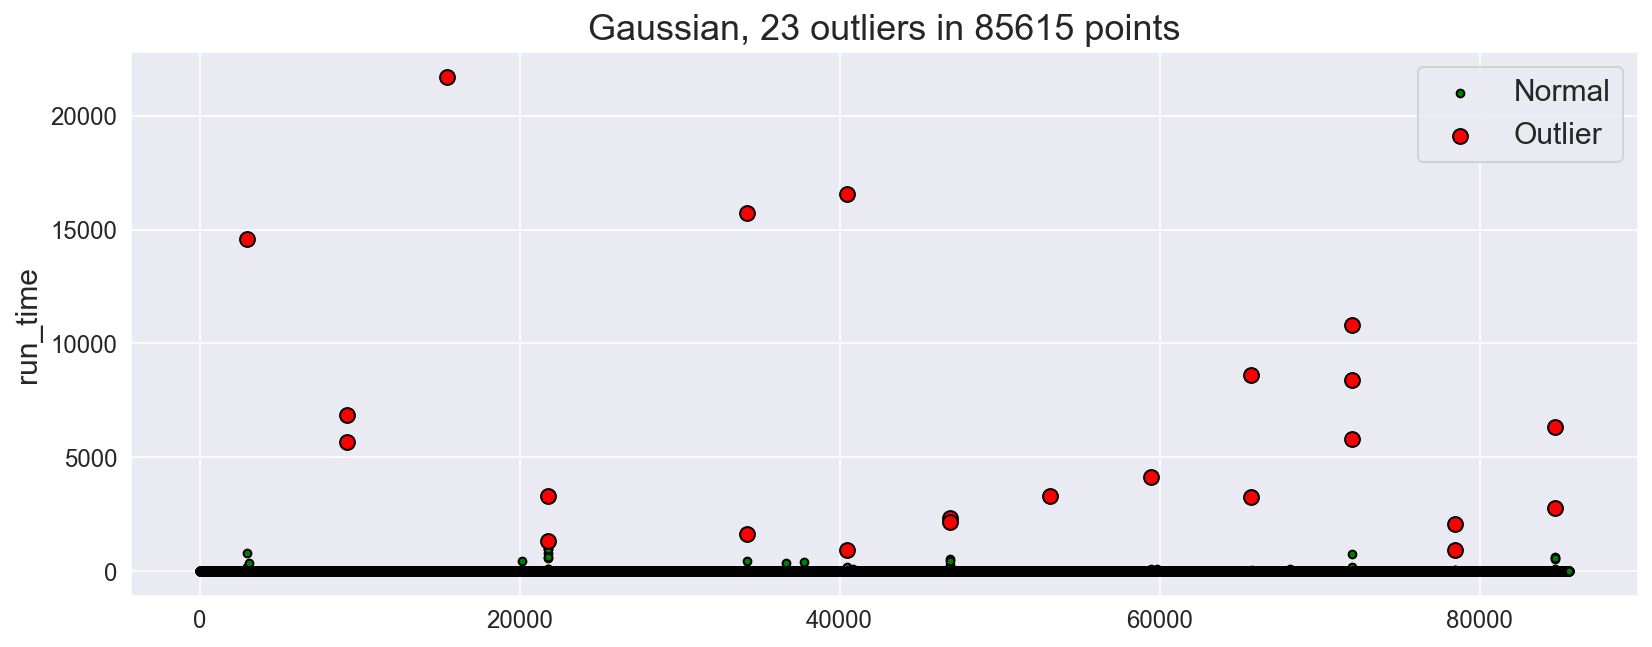

total time used: 5.450689077377319


In [16]:
start = time.time()
for i in range(10): # test 10 random samples
    np.random.seed(i)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    #print(j, func_name)
    sample = sample_portion(run_time, func_name)
    moving_gaussian(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

## Moving Quantile Range

In [17]:
def moving_quantile(df, window_frac = 0.15, c = 6, plot=True):
    window = int(window_frac * len(df))
    q1 = df.run_time.rolling(window = window).quantile(0.1)
    q3 = df.run_time.rolling(window = window).quantile(0.9)
    q1.iloc[:(window-1)] = q1.iloc[window]
    q3.iloc[:(window-1)] = q3.iloc[window]

    upper = q3 + c * (q3 - q1)
    lower = q1 - c * (q3 - q1)
    a1 = df.run_time > upper
    a2 = df.run_time < lower
    
    anomalies = np.logical_or(a1, a2)
    normal = np.logical_not(anomalies)
    outlier = df[anomalies]
    normal = df[normal]
    
    if plot:
        plot_result(outlier, normal, 'Tukey')        
    return outlier, normal

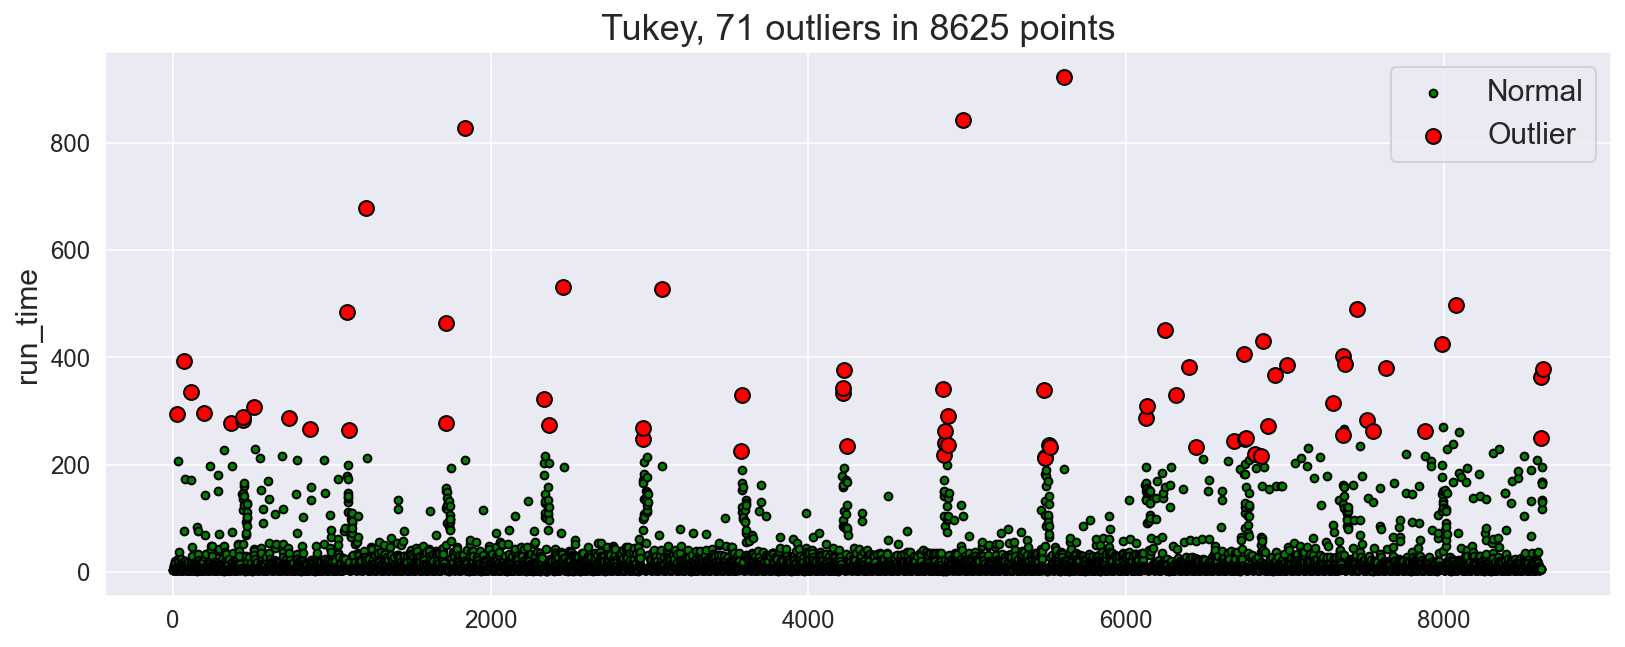

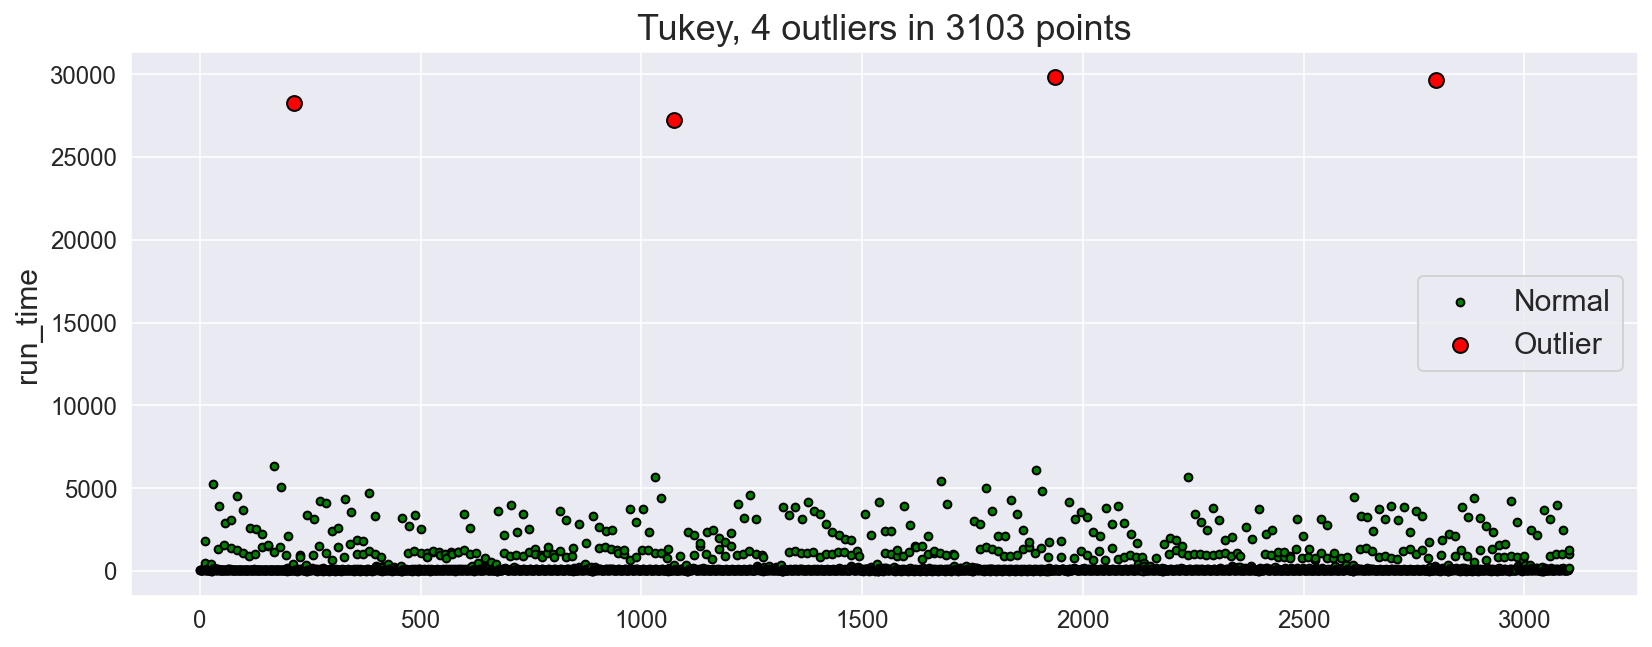

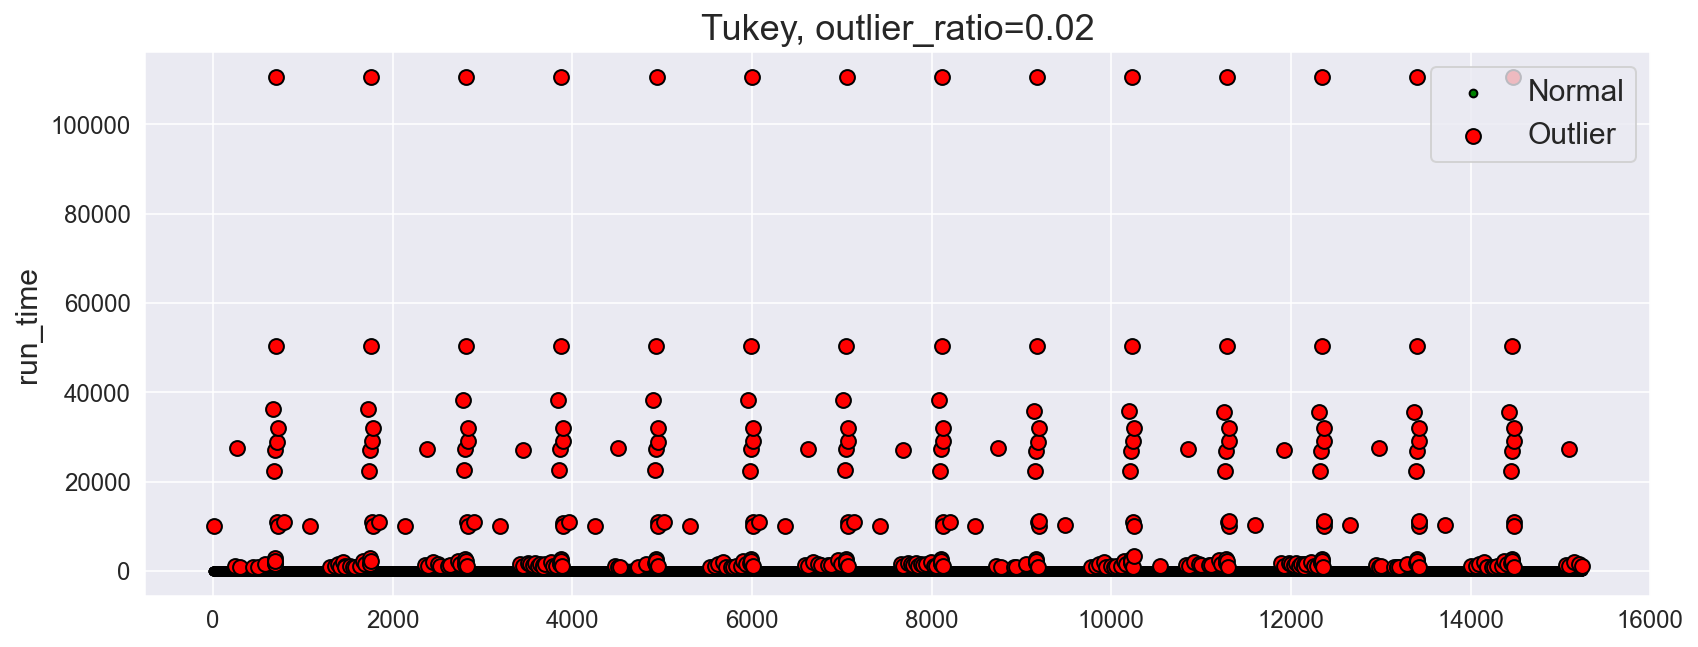

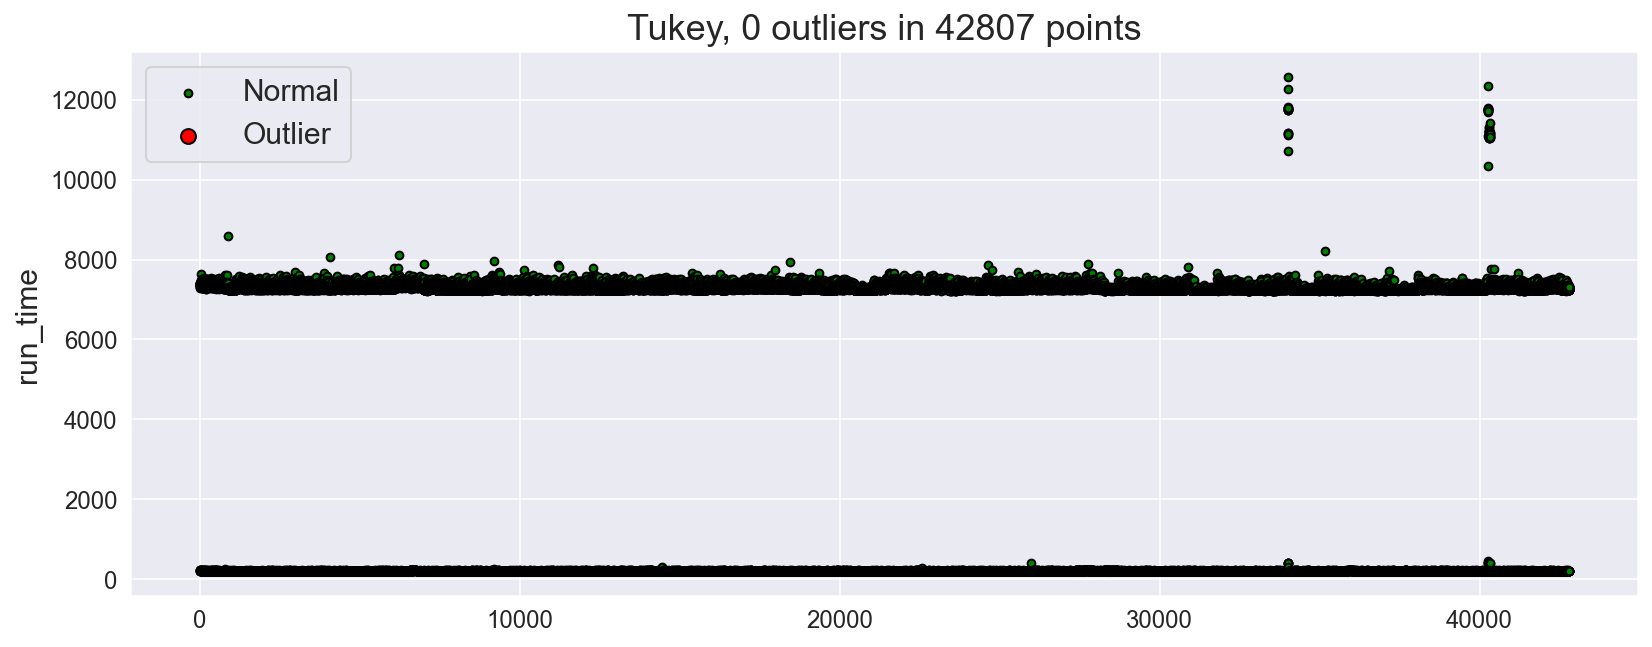

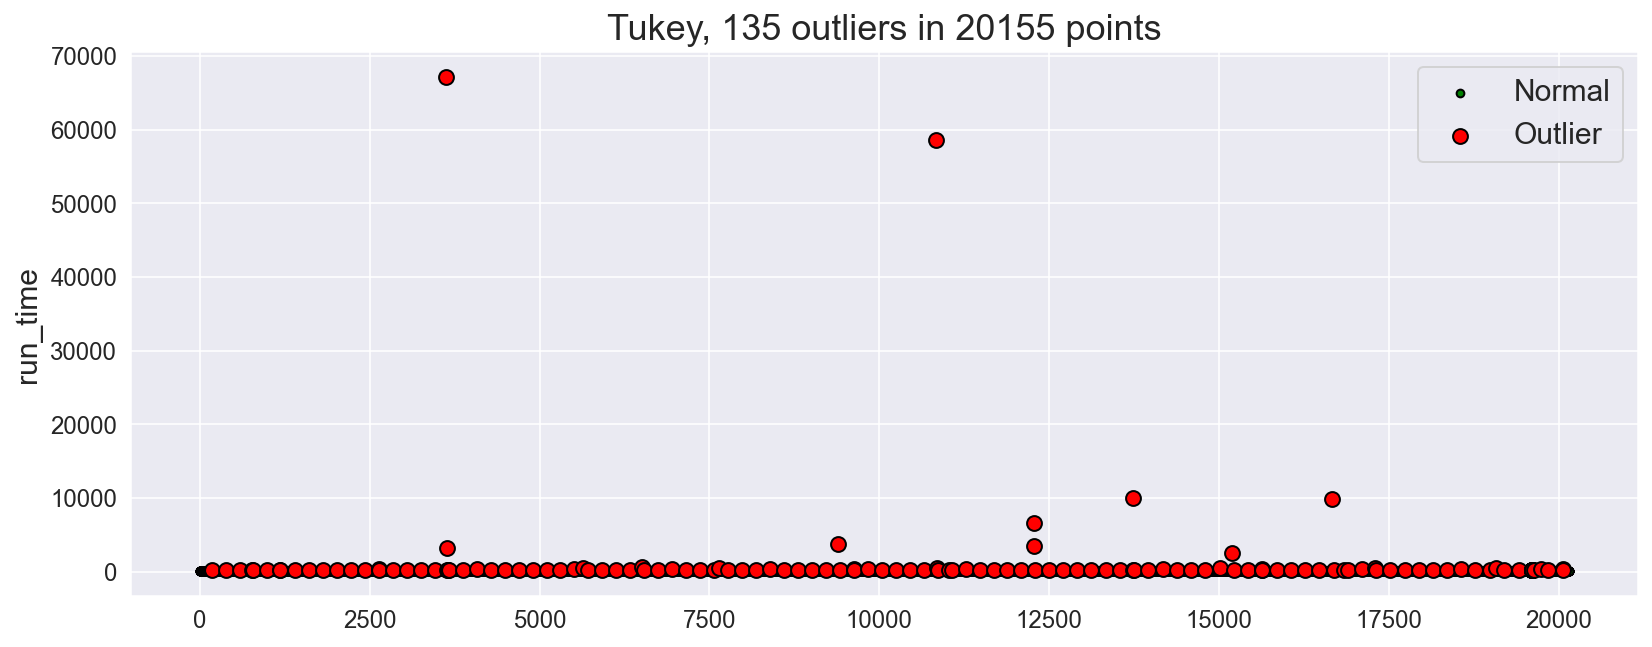

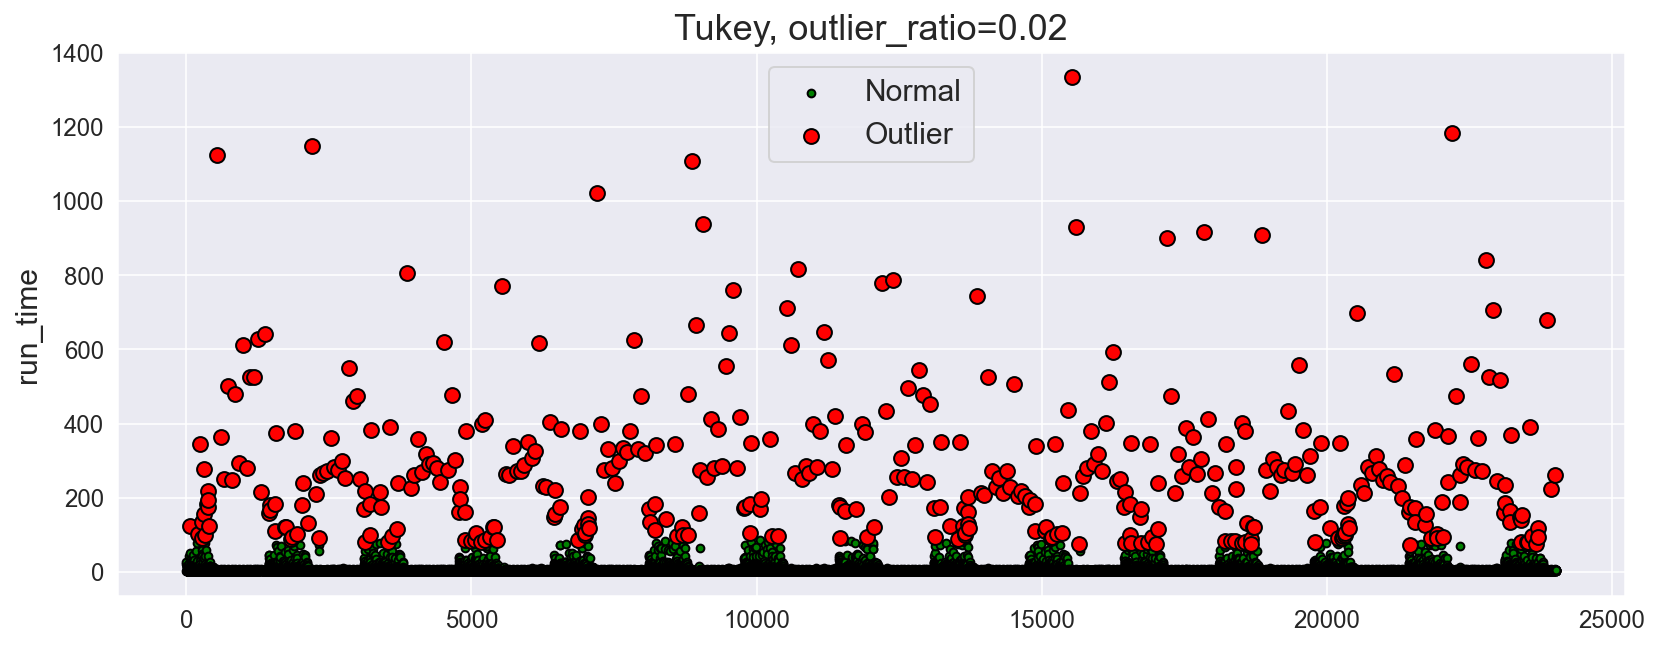

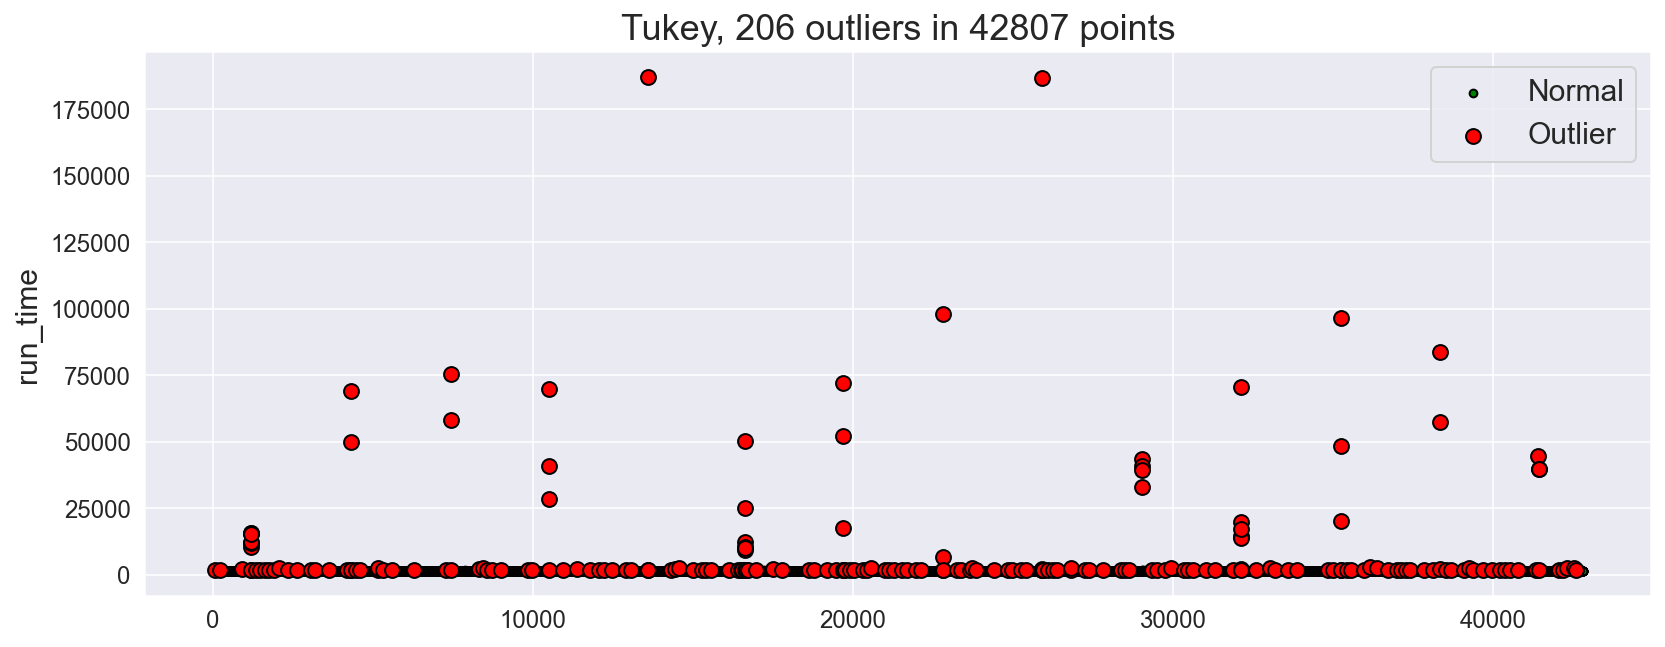

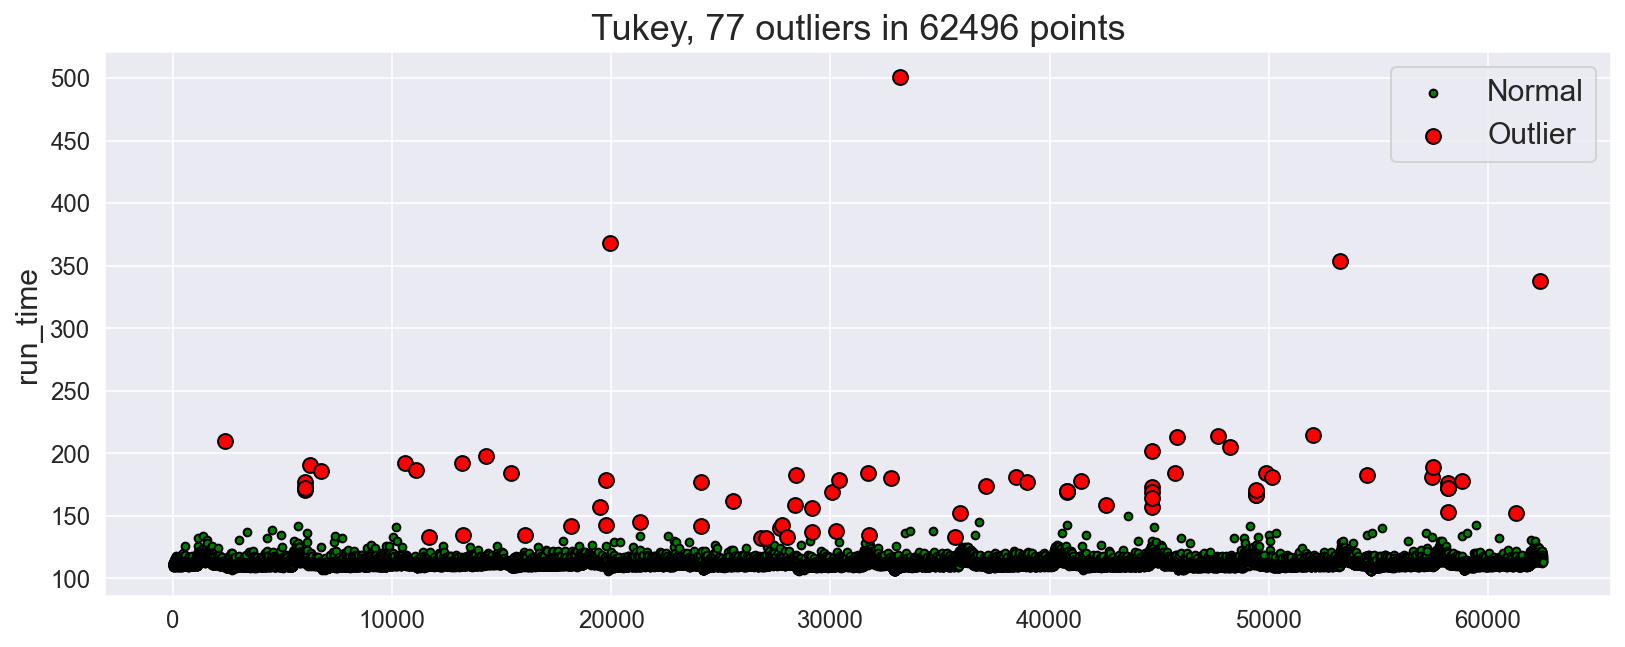

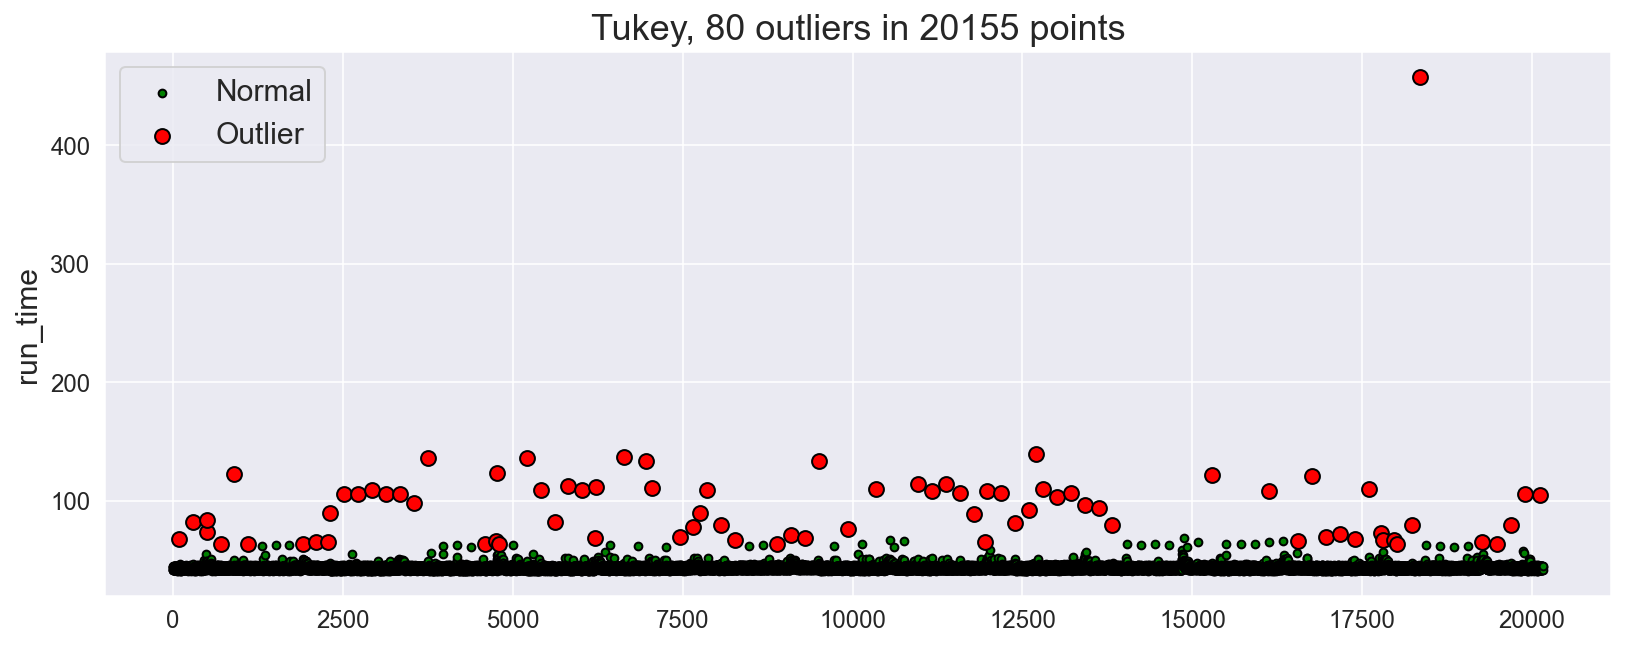

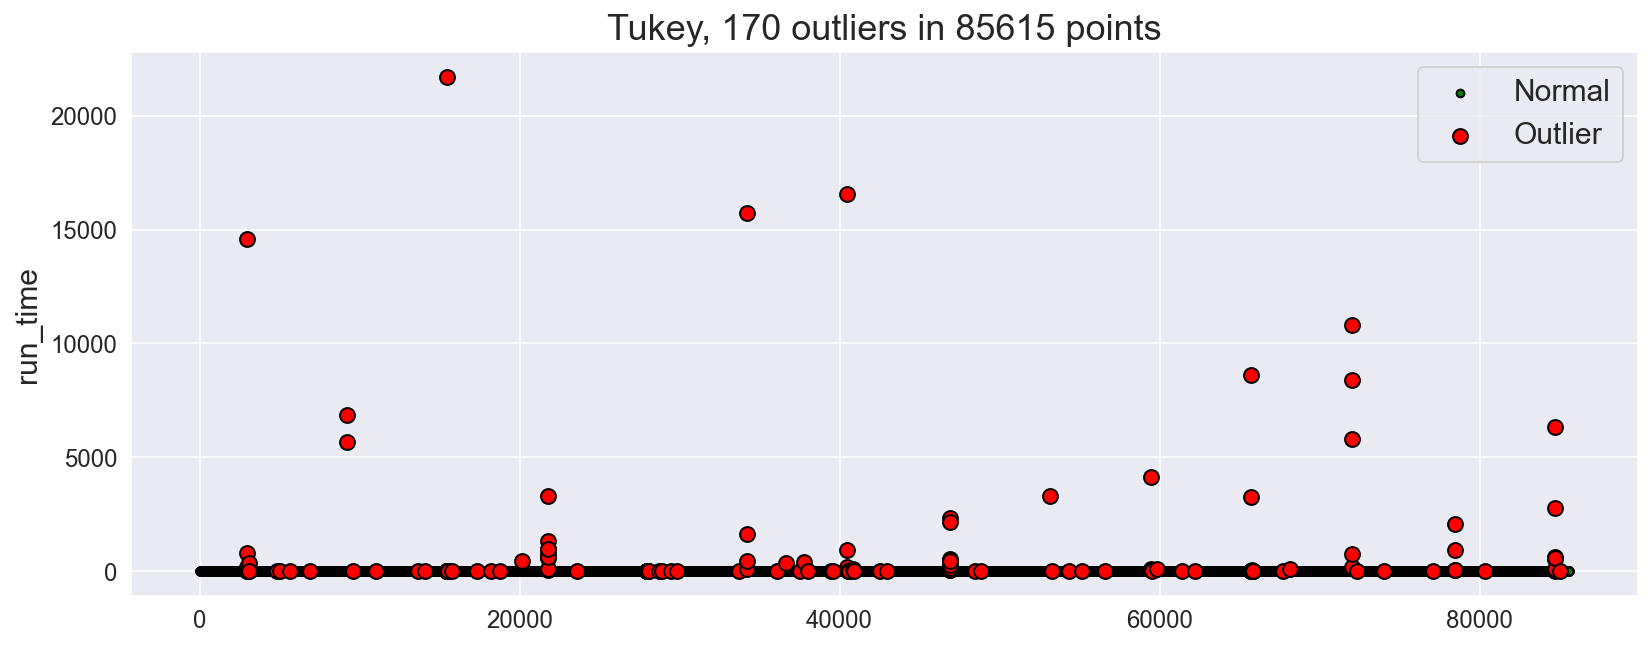

total time used: 5.903402805328369


In [18]:
start = time.time()
for i in range(10): # test 10 random samples
    np.random.seed(i)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    sample = sample_portion(run_time, func_name)
    moving_quantile(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

## MinClusterDetector

`MinClusterDetector` treats multivariate time series as independent points in a high-dimensional space, divides them into clusters, and identifies values in the smallest cluster as anomalous. This may help capturing outliers in high-dimensional space.

In [19]:
from adtk.data import validate_series

def transform_adtk(df):
    tmp = pd.to_datetime(df.index.values, unit='D',
               origin=pd.Timestamp('2020-01-01'))
    idx = pd.Index(tmp, name='timestamp')
    
    data = {'run_time': df['run_time'].values}
    df_trans = pd.DataFrame(data=data, index=idx)
    df_trans.name = df.name
    return df_trans

sample_adtk = transform_adtk(sample)
validate_series(sample_adtk); # validate the dataframe conforms with adtk requirement

In [20]:
from adtk.detector import MinClusterDetector
from sklearn.cluster import KMeans

def min_cluster(df, n_clusters = 2, plot=True):
    min_cluster_detector = MinClusterDetector(KMeans(n_clusters = n_clusters))
    df = transform_adtk(df)
    anomalies = min_cluster_detector.fit_detect(df)
    normal = df[~anomalies]
    outlier = df[anomalies]
    
    if plot:
        plot_result(outlier, normal, 'Min Cluster')
    
    return outlier, normal

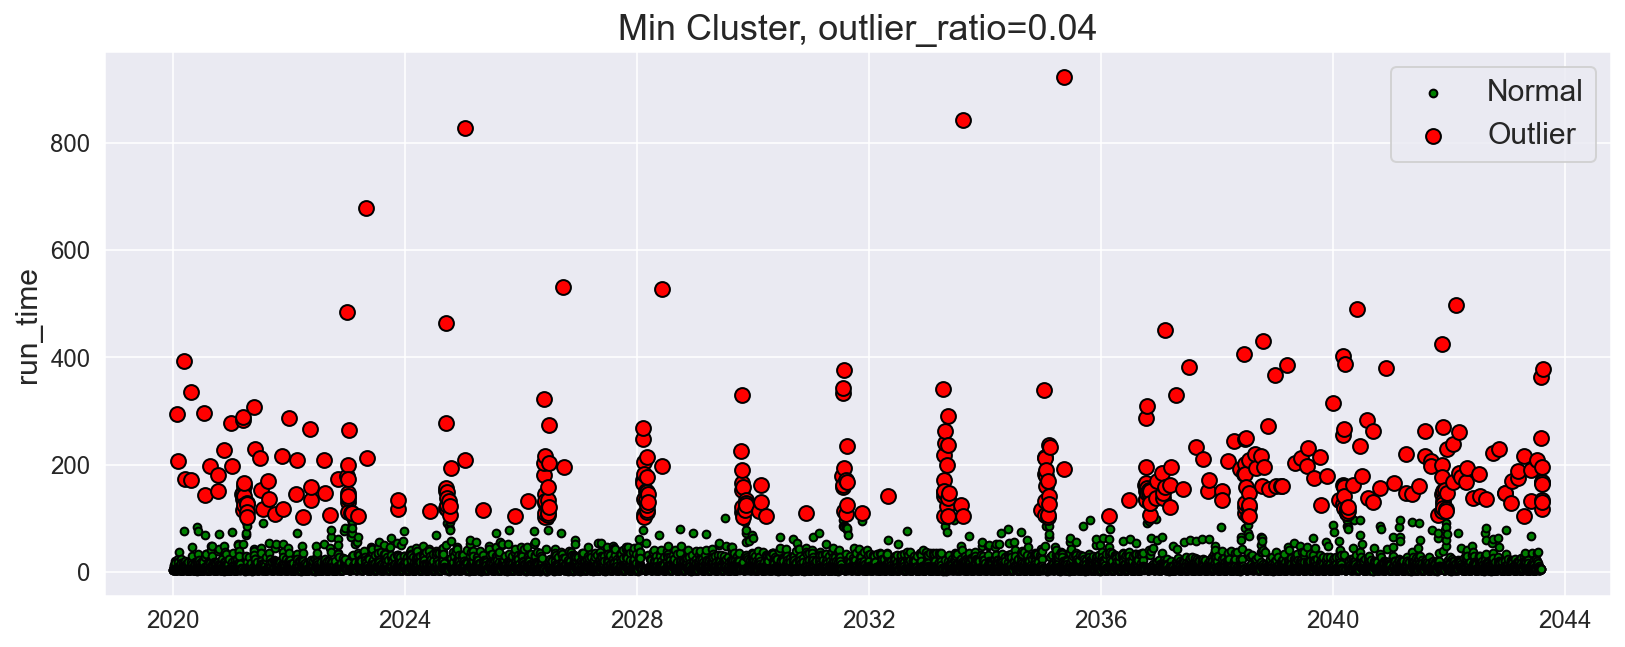

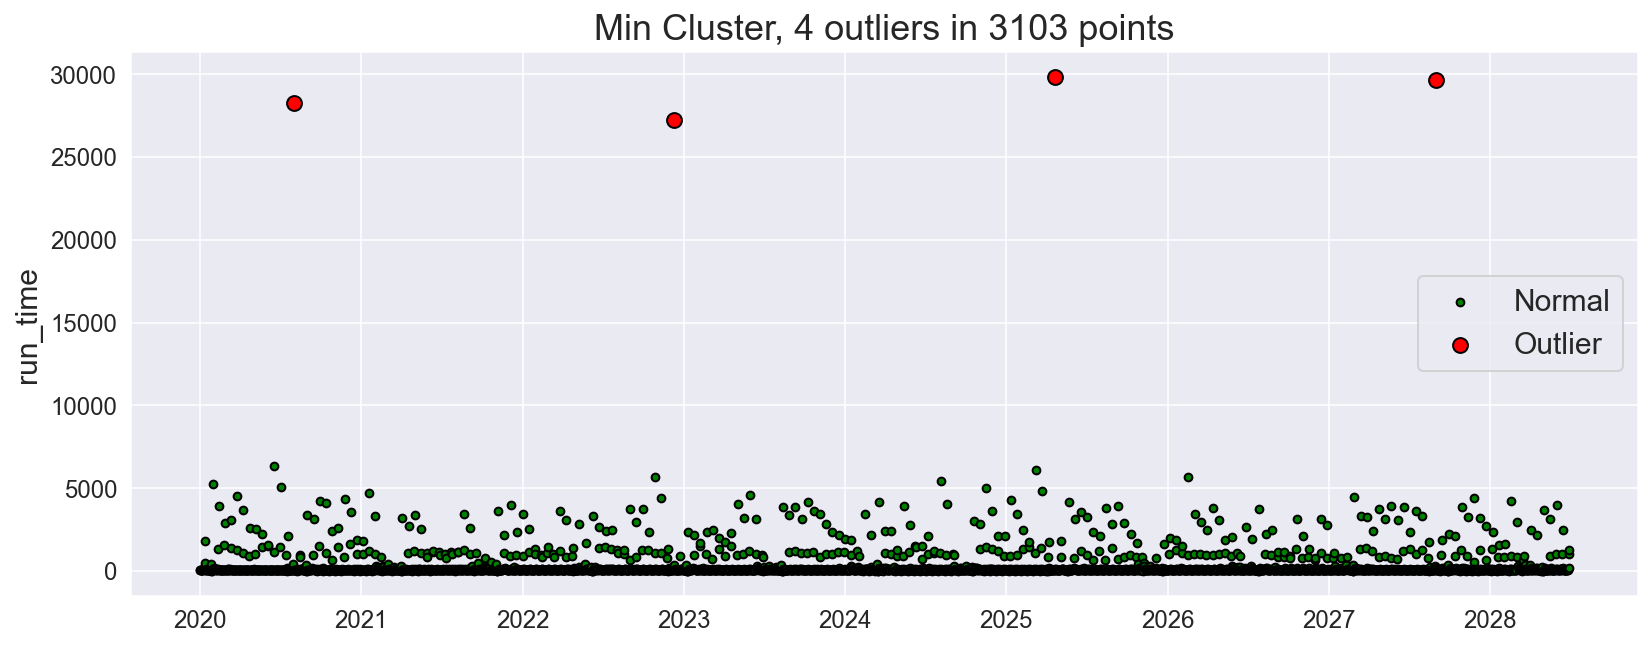

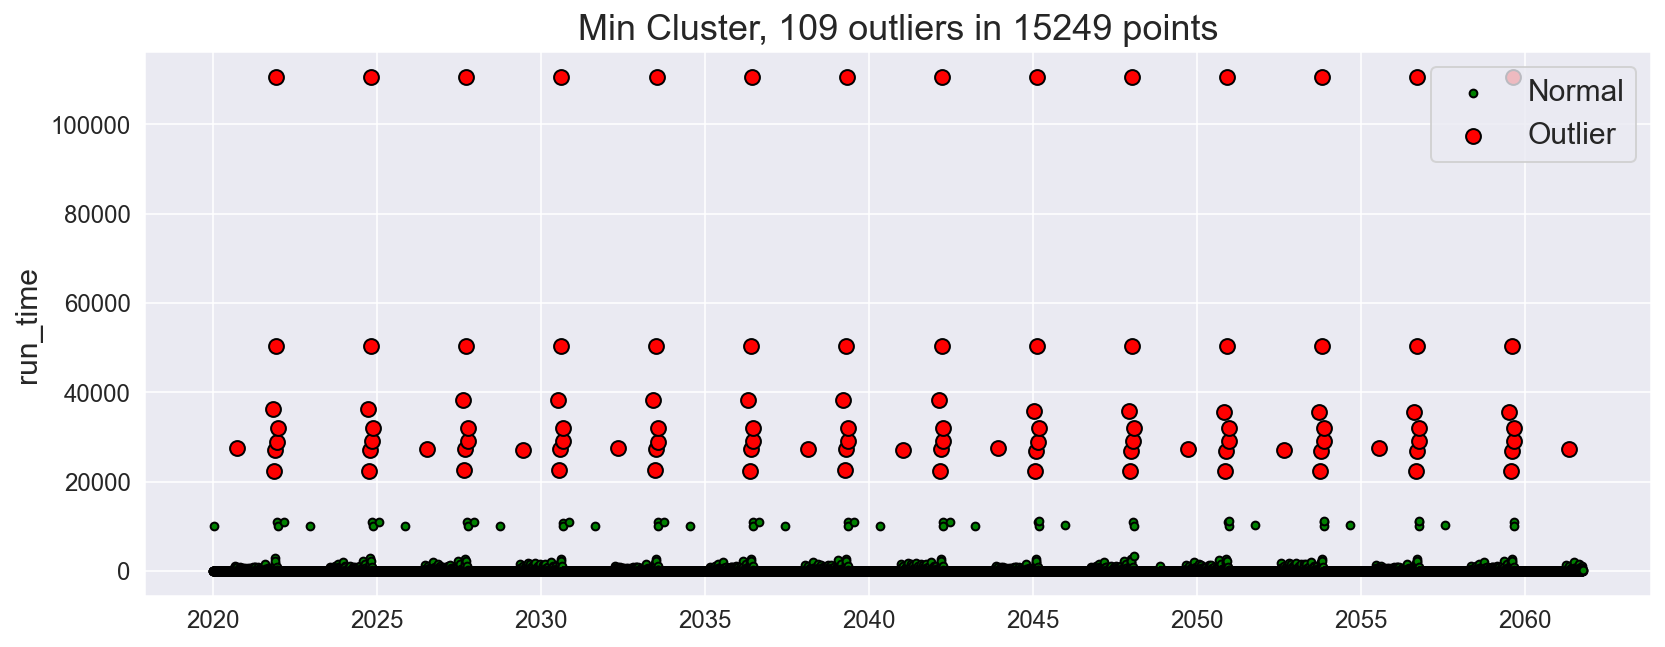

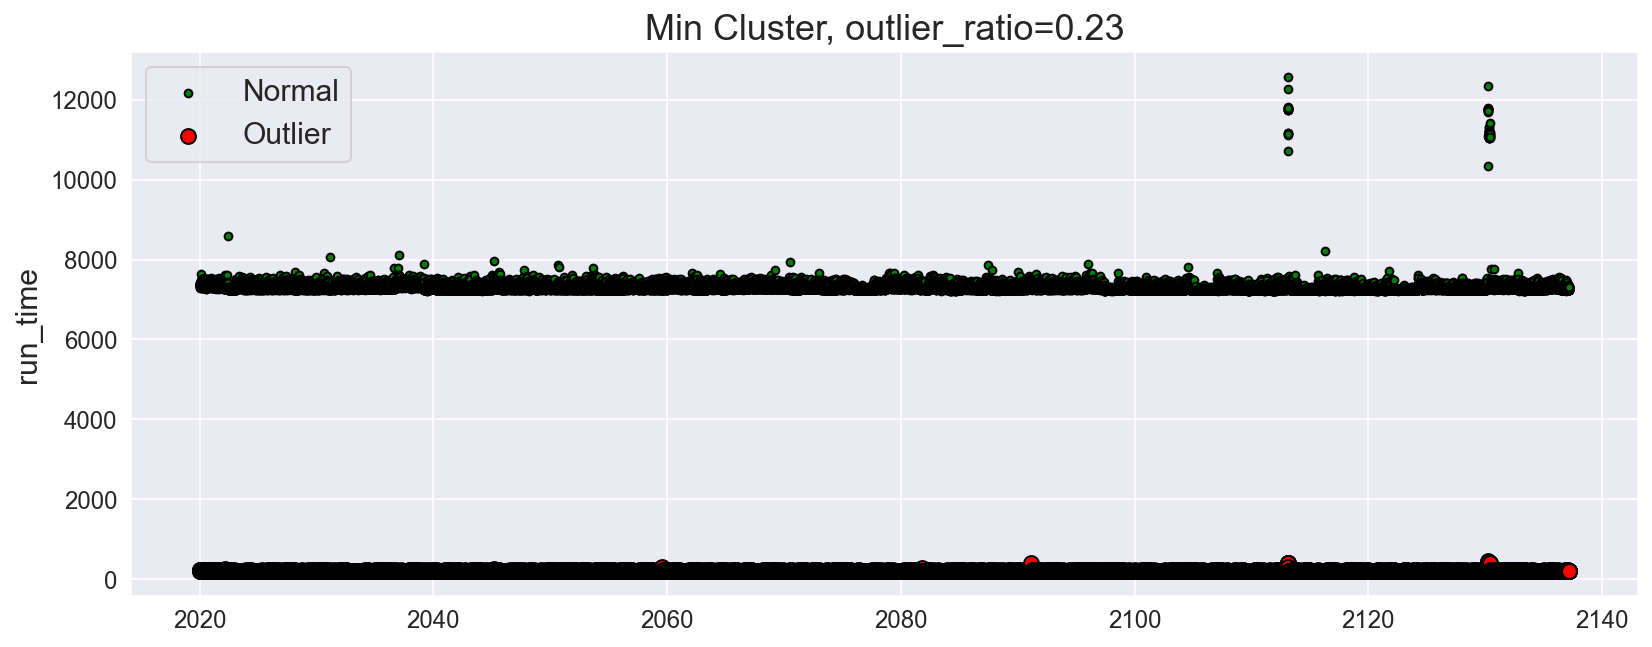

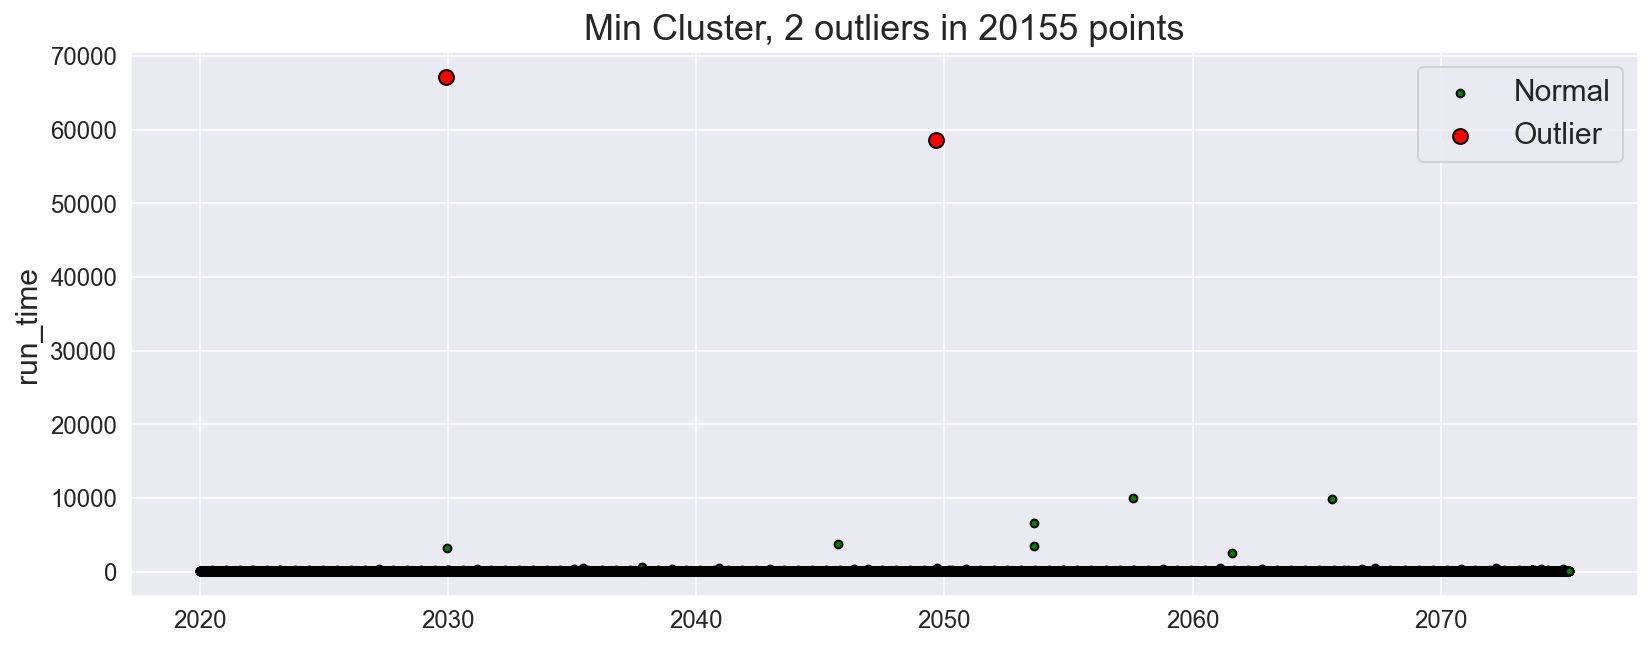

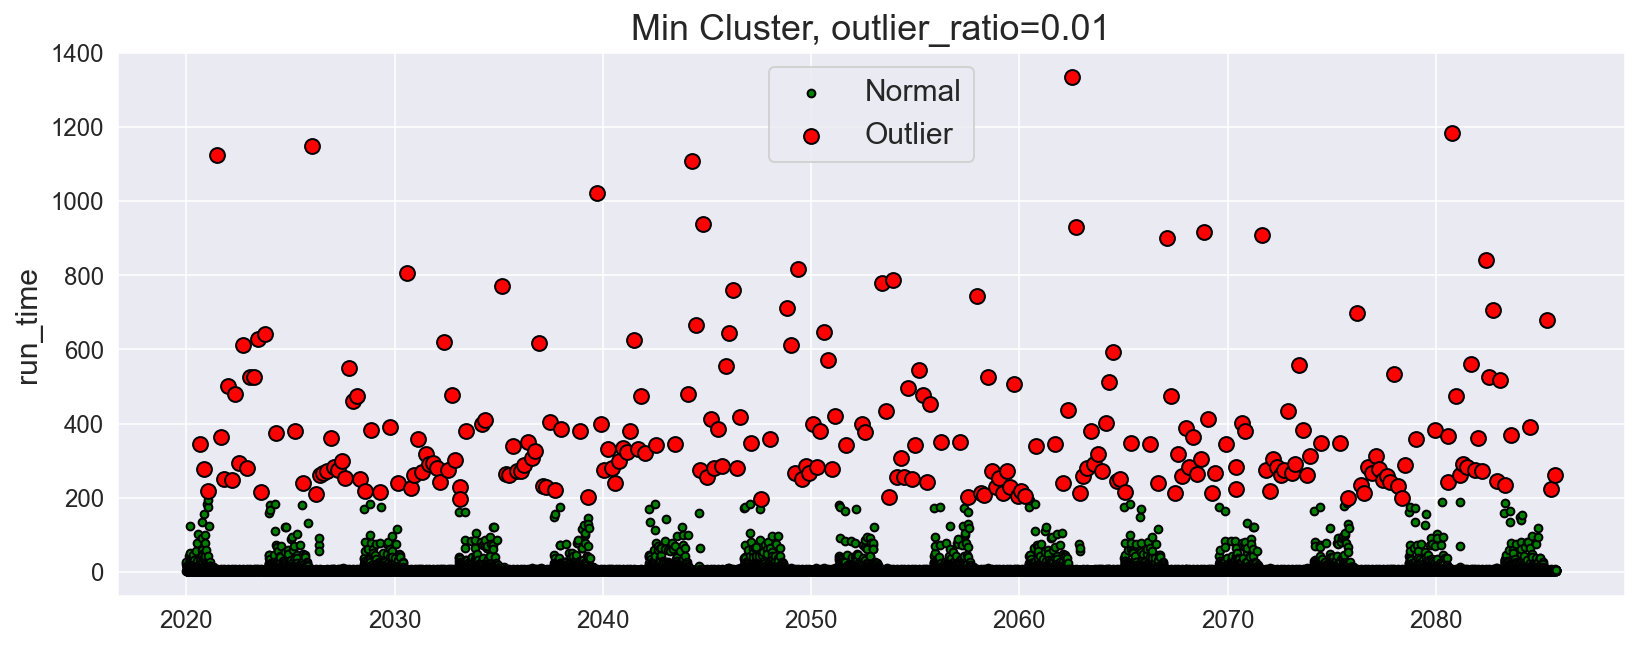

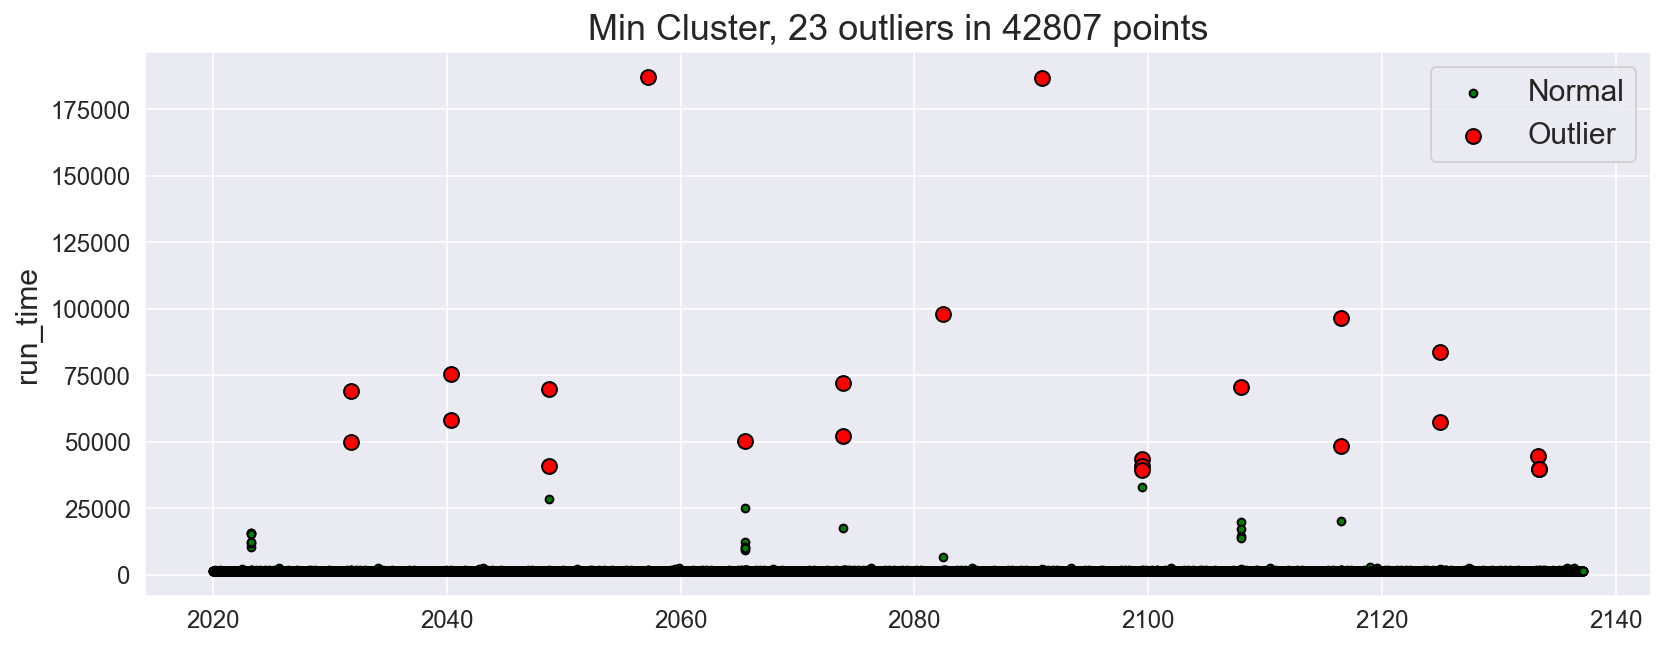

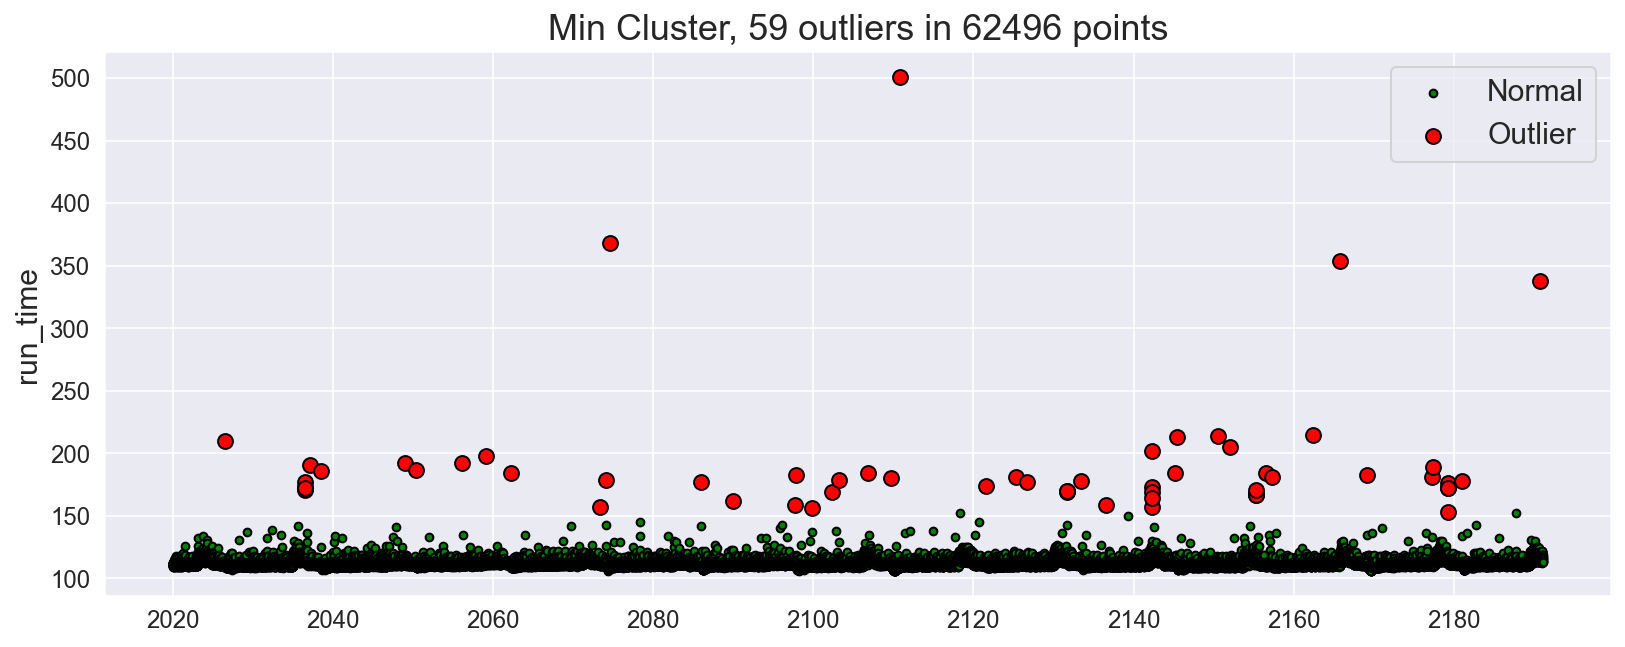

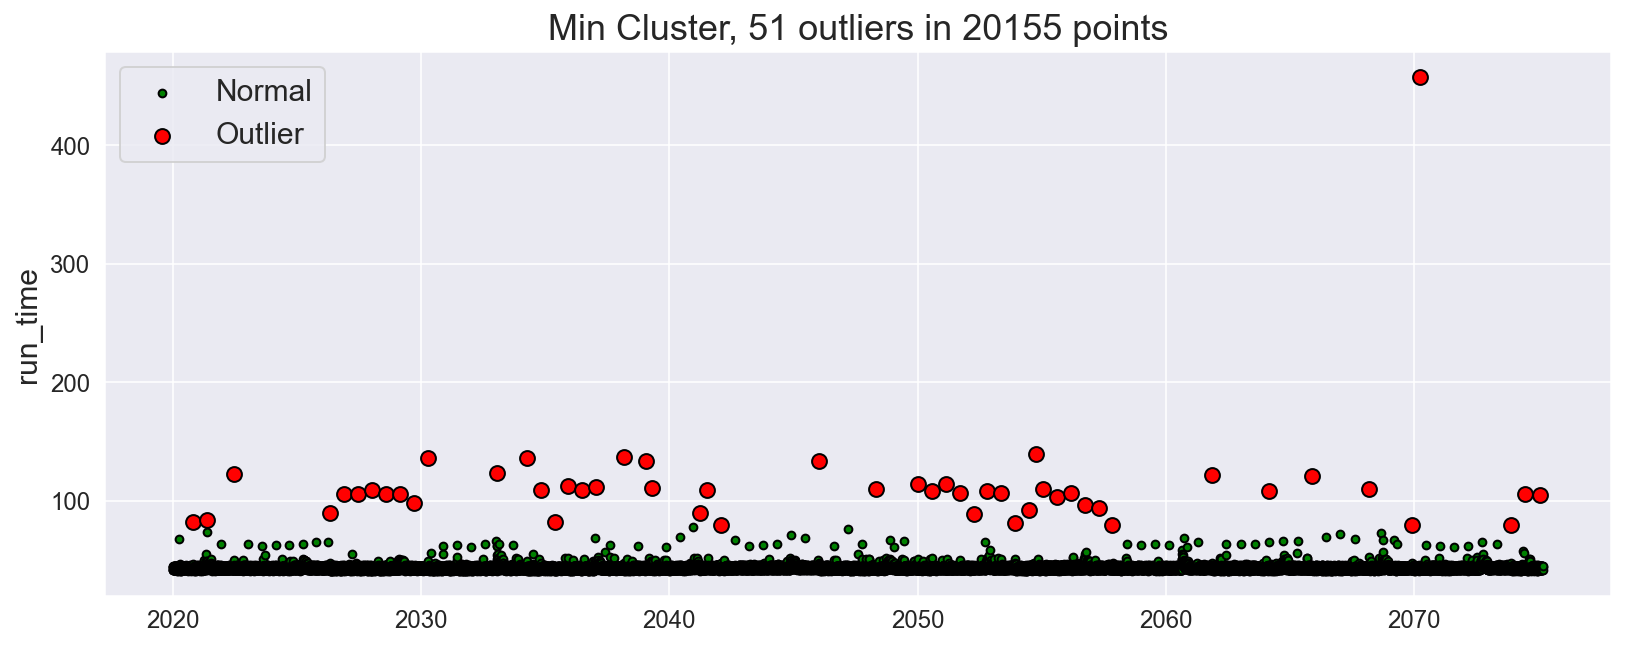

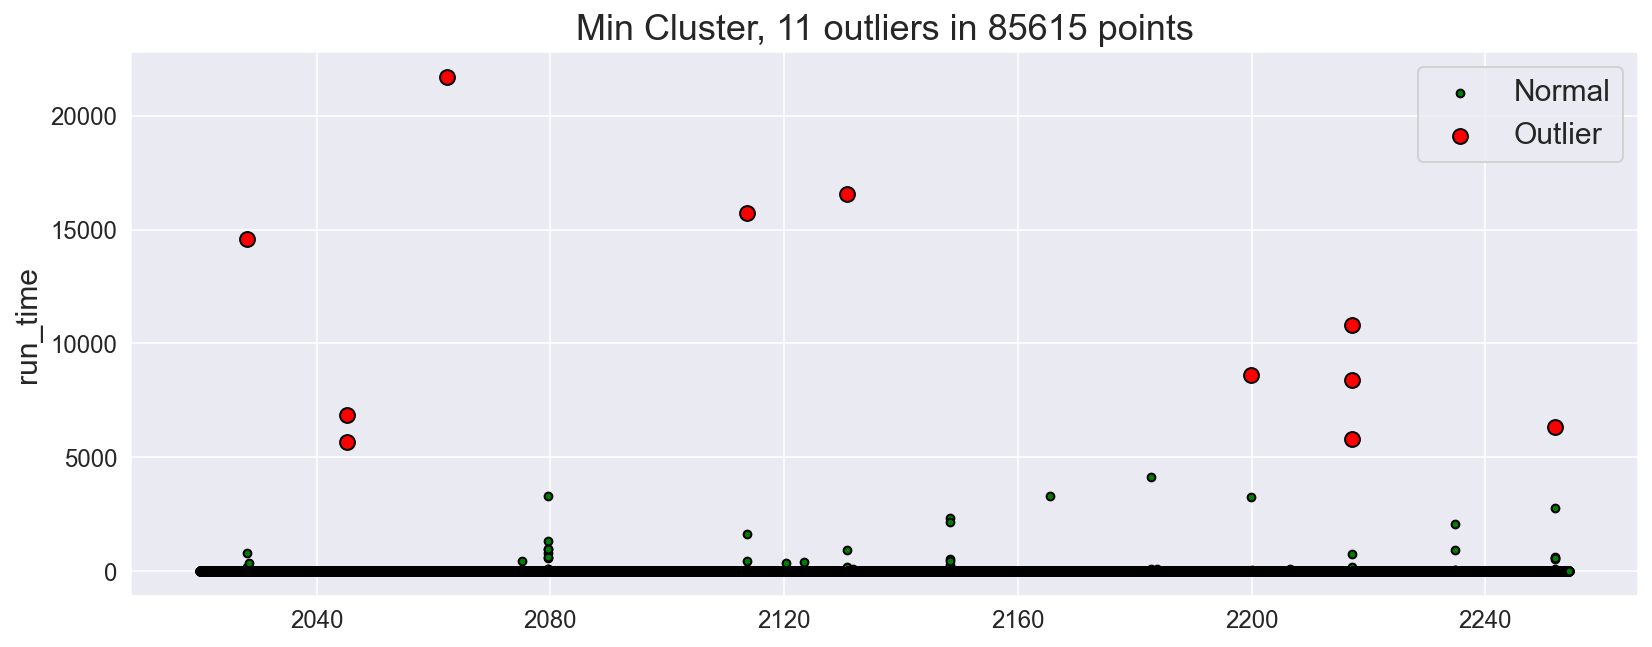

total time used: 7.528658866882324


In [21]:
start = time.time()
for i in range(10): # test 10 random samples
    np.random.seed(i)
    j = np.random.randint(len(subset))
    func_name = subset.iloc[j].func_name
    sample = sample_portion(run_time, func_name)
    min_cluster(sample, plot=True);
end = time.time()
print("total time used: {}".format(end - start))

## Relative Entropy Detector

In [57]:
# from base import NAB_Dataset
from relative_entropy_detector import RelativeEntropyDetector

In [63]:
from base import AnomalyDetector

In [65]:
def relative_entropy(df, window_frac = 0.01, bins = 40, plot = True):
    #dataset = NAB_Dataset(df)
    re_ad = RelativeEntropyDetector(dataset)
    window = int(window_frac * len(df))
    re_ad.W = window
    re_ad.N_bins = bins
    result = re_ad.run();
    outlier = result[result.anomaly_score > 0]
    normal = result[result.anomaly_score == 0]
    if plot:
        plot_result(outlier, normal, "RE")
    return outlier, normal

In [66]:
re_ad = RelativeEntropyDetector(sample.iloc[:2000])
result = re_ad.run();

AttributeError: 'DataFrame' object has no attribute 'func_name'

In [51]:
outlier = result[result.anomaly_score > 0]

In [53]:
normal = result[result.anomaly_score == 0]

In [54]:
normal

,value,anomaly_score
0,12,0.0
1,12,0.0
2,11,0.0
3,12,0.0
4,12,0.0
...,...,...
1995,11,0.0
1996,12,0.0
1997,11,0.0
1998,11,0.0
